# Load libraries

In [1]:
library(ggplot2)
library(DiffBind)
library(DESeq2)
library(edgeR)
library(tidyr)
library(dplyr)
library(rtracklayer)
library(ChIPseeker)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(eulerr)
library(trackViewer)
library(org.Mm.eg.db)
library(extrafont)


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



# Run DR vs. NR GR DiffBind analysis and generate PCA and MA plots

In [3]:
# Create DiffBind object
CR01 <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/sample_sheet_01.csv", peakFormat="narrow")
CR01_count <- dba.count(CR01,summits=150,minOverlap=2,bParallel = TRUE)

DR_R1 Astro CR DR DR 1 bed

DR_R2 Astro CR DR DR 2 bed

DR_R3 Astro CR DR DR 3 bed

NR_R1 Astro CR NR NR 1 bed

NR_R2 Astro CR NR NR 2 bed

NR_R3 Astro CR NR NR 3 bed

Computing summits...

Re-centering peaks...



6 Samples, 12459 sites in matrix:
     ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 DR_R1  Astro     CR        DR        DR         1 5005092 0.03
2 DR_R2  Astro     CR        DR        DR         2 6312296 0.02
3 DR_R3  Astro     CR        DR        DR         3 3269938 0.05
4 NR_R1  Astro     CR        NR        NR         1 5574968 0.12
5 NR_R2  Astro     CR        NR        NR         2 3373049 0.07
6 NR_R3  Astro     CR        NR        NR         3 5923862 0.17

In [4]:
# Normalize counts
CR01_count <- dba.normalize(CR01_count, method = DBA_ALL_METHODS)

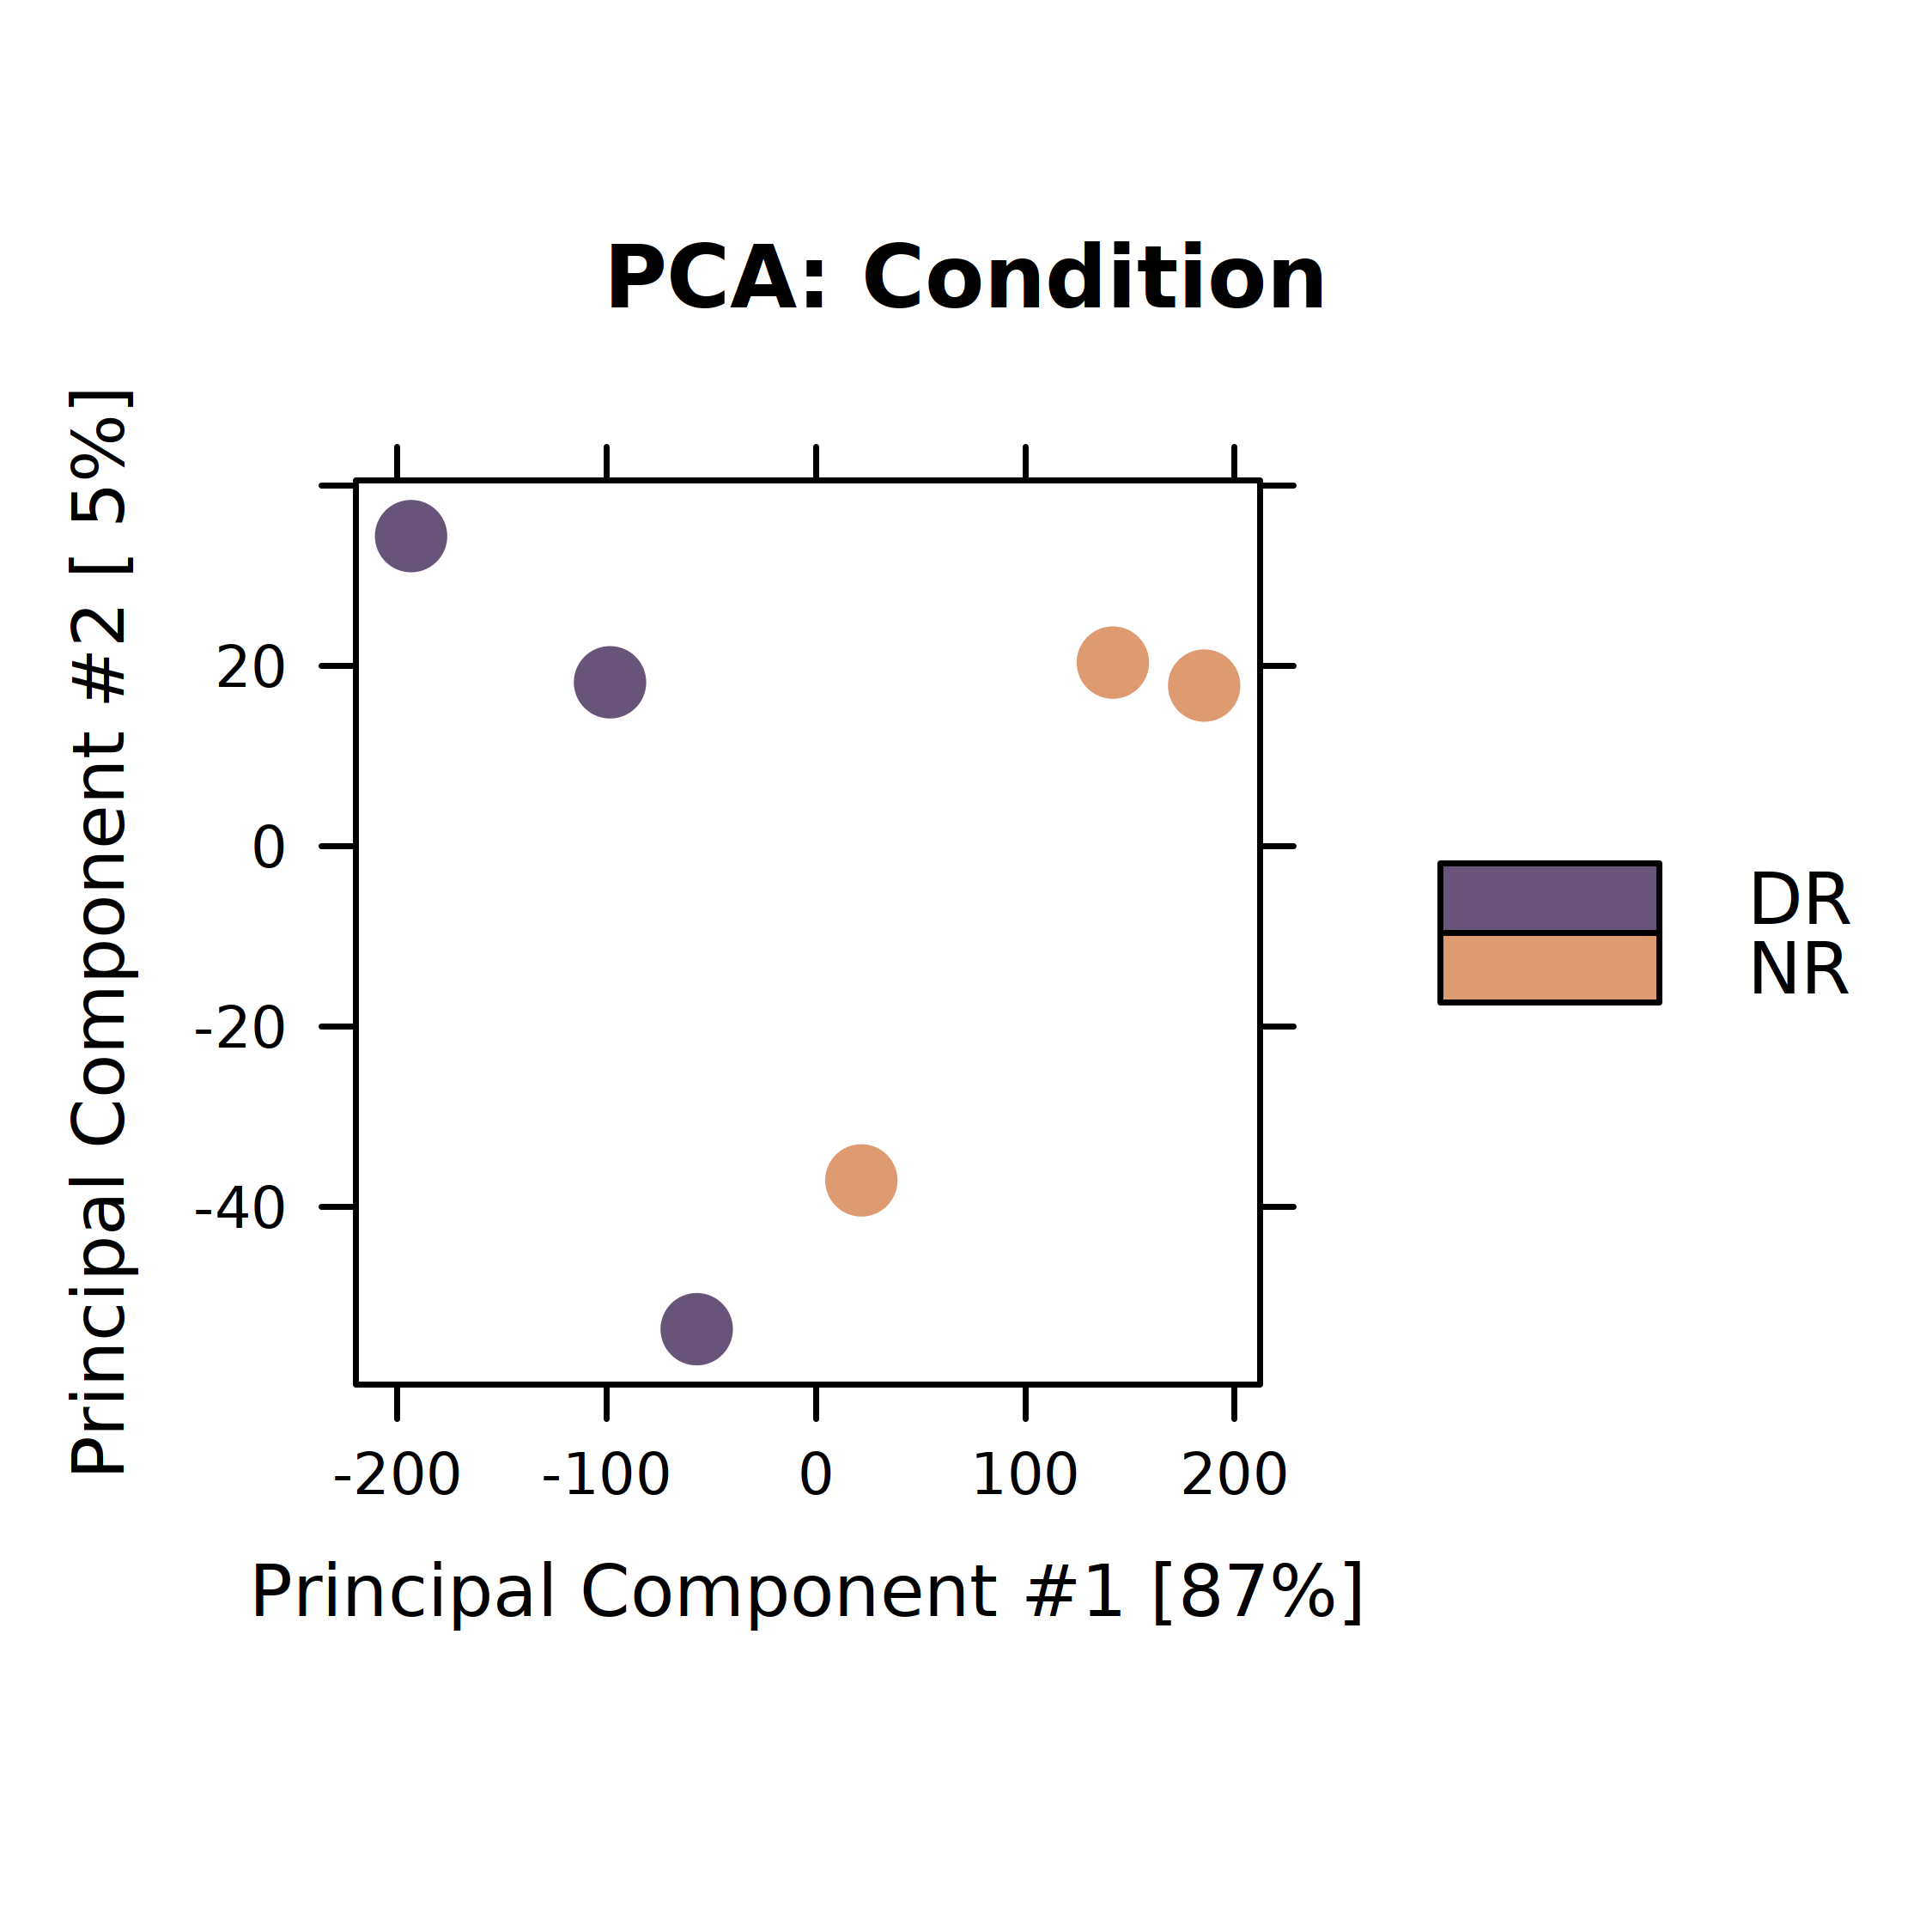

In [5]:
# Generate PCA plot
options(repr.plot.width=4.5, repr.plot.height=4.5,repr.plot.res=500)
dba.plotPCA(CR01_count,
             dotSize=2,
            vColors = c('#675478','#DE9B71'))

In [6]:
# Establish constrast
CR01_count_contrast <- dba.contrast(CR01_count, reorderMeta=list(Condition="DR"),minMembers=2)

Computing results names...



In [7]:
# Run analysis
CR01_count_edger <- dba.analyze(CR01_count_contrast,
                                method=DBA_EDGER,
                                bBlacklist=FALSE,
                                bGreylist = FALSE)

Analyzing...



In [18]:
# Generate report
CR01_count_edger_report_str <- as.data.frame(dba.report(CR01_count_edger,th=0.01,fold=0.25,method=DBA_EDGER))

In [10]:
# Annotate GR sites to mm10
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- annotatePeak('/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_count_edger_report_str_FC25.bed',
                         tssRegion=c(-1000, 1000),
                         genomicAnnotationPriority = c("Promoter", "Exon", "Intron",
                                                        "Downstream", "Intergenic"),
                         level = 'gene',
                         TxDb=txdb, annoDb="org.Mm.eg.db")

>> loading peak file...				 2025-05-27 06:35:36 PM 
>> preparing features information...		 2025-05-27 06:35:36 PM 
>> identifying nearest features...		 2025-05-27 06:35:37 PM 
>> calculating distance from peak to TSS...	 2025-05-27 06:35:38 PM 
>> assigning genomic annotation...		 2025-05-27 06:35:38 PM 
>> adding gene annotation...			 2025-05-27 06:35:47 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-05-27 06:35:47 PM 
>> done...					 2025-05-27 06:35:47 PM 


In [22]:
# Export data with nearest gene annotation
write.table(cbind(CR01_count_edger_report_str,as.data.frame(peakAnno)$SYMBOL),
            '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/SuppTable5.csv',
            quote=FALSE,
            row.names=FALSE,
            col.names=TRUE,
            sep=',')

In [52]:
# Export as BED file
rtracklayer::export(CR01_count_edger_report_str,
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_count_edger_report_str_FC25.bed',
                    format = 'BED')

In [114]:
# Export all sites to df
CR01_count_edger_report_str_df <- as.data.frame(dba.report(CR01_count_edger,th=0.01,fold=0.25,method=DBA_EDGER))
CR01_count_edger_df <- as.data.frame(dba.report(CR01_count_edger,th=1,method=DBA_EDGER))

In [115]:
# Add a column of NAs
CR01_count_edger_df$significant <- "NO"

# Set differential motifs to "experience-induced or -repressed"
CR01_count_edger_df$significant[ (CR01_count_edger_df$Fold > 0) & (paste0(CR01_count_edger_df$seqnames,CR01_count_edger_df$start,CR01_count_edger_df$end) %in%
paste0(CR01_count_edger_report_str_df$seqnames,CR01_count_edger_report_str_df$start,CR01_count_edger_report_str_df$end))] <- "Up"
CR01_count_edger_df$significant[ (CR01_count_edger_df$Fold < 0) & (paste0(CR01_count_edger_df$seqnames,CR01_count_edger_df$start,CR01_count_edger_df$end) %in%
paste0(CR01_count_edger_report_str_df$seqnames,CR01_count_edger_report_str_df$start,CR01_count_edger_report_str_df$end))] <- "Down"

CR01_count_edger_df$significant <- factor(CR01_count_edger_df$significant,levels =c('Up','Down','NO'))

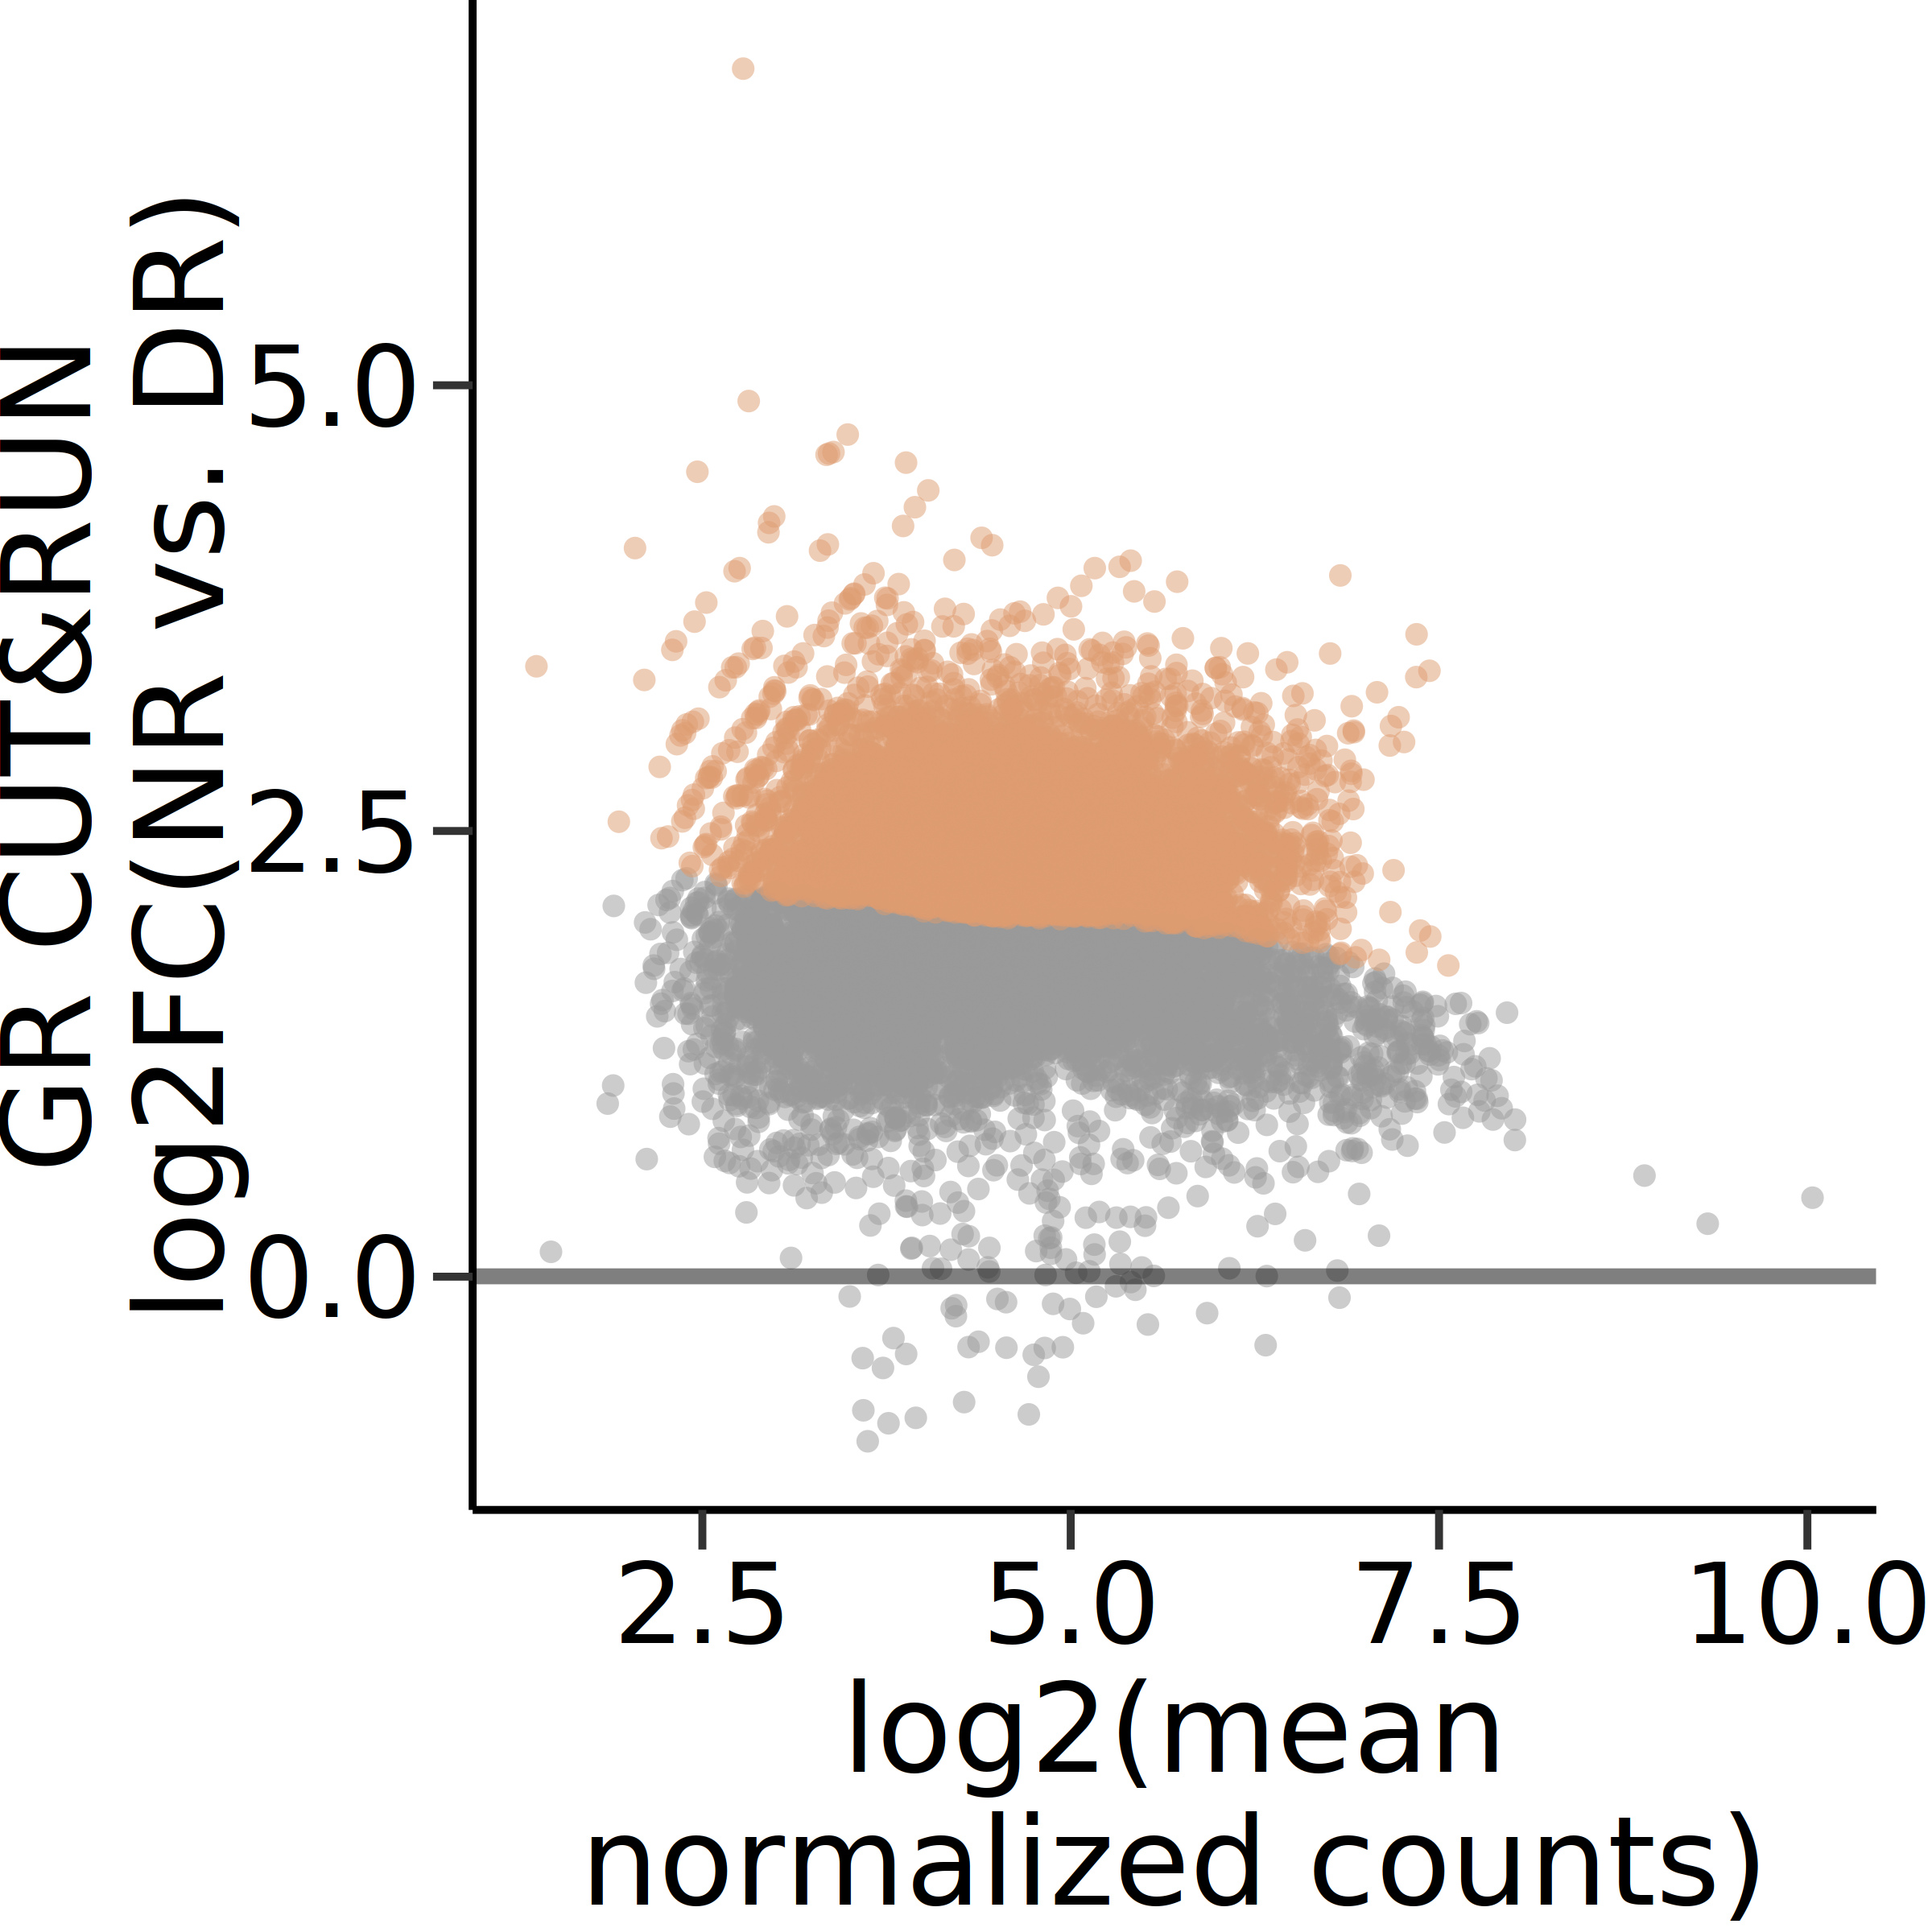

In [120]:
# Make MA plot
options(repr.plot.width=4.8, repr.plot.height=4.8,repr.plot.res=500)

p8 <- ggplot(data = CR01_count_edger_df %>% arrange(desc(significant)), aes(x = Conc, y = Fold, col = significant)) + 
geom_point(shape=16,size=1.5,alpha=0.5) + 
    geom_hline(yintercept=0, linetype="solid",alpha=0.5, color = "black",size=1) +
    theme_classic() + 
    scale_color_manual(values = c("#DE9B71",
                                  "grey60",
                                  "#675478"
                                  )) +
    theme(axis.text = element_text(size = 20, color = 'black'),
          axis.title = element_text(size = 22),
          axis.ticks.length=unit(.25, "cm"),
          plot.margin=margin(0,10,0,0),
          plot.title = element_text(size = 20, hjust = 0.5),
          legend.position = 'None') +
    xlab('log2(mean\nnormalized counts)') +
    ylab('GR CUT&RUN\nlog2FC(NR vs. DR)') 

p8

# Annotate peaks to promoter sites vs. non-promoter site with ChIPseeker

In [123]:
# Annotate GR sites to mm10
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- annotatePeak('/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_count_edger_report_str_FC25.bed',
                         tssRegion=c(-1000, 1000),
                         genomicAnnotationPriority = c("Promoter", "Exon", "Intron",
                                                        "Downstream", "Intergenic"),
                         level = 'gene',
                         TxDb=txdb, annoDb="org.Mm.eg.db")

>> loading peak file...				 2025-05-05 03:19:21 PM 
>> preparing features information...		 2025-05-05 03:19:21 PM 
>> identifying nearest features...		 2025-05-05 03:19:21 PM 
>> calculating distance from peak to TSS...	 2025-05-05 03:19:23 PM 
>> assigning genomic annotation...		 2025-05-05 03:19:23 PM 
>> adding gene annotation...			 2025-05-05 03:19:25 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2025-05-05 03:19:25 PM 
>> done...					 2025-05-05 03:19:25 PM 


In [33]:
# Generate dataframe of peak location for barplot
anno_df <- as.data.frame(t(data.frame(Promoter = 42.82754224,
                      Exon = 6.37551801 + 4.92508766,
                      Intron = 11.33248326 + 15.74752949,
                      Intergenic = 0.07969398 + 18.71214536)))
anno_df$x <- 1
anno_df$anno <- rownames(anno_df)
anno_df$anno <- factor(anno_df$anno, levels = c('Intergenic','Intron','Exon','Promoter'))

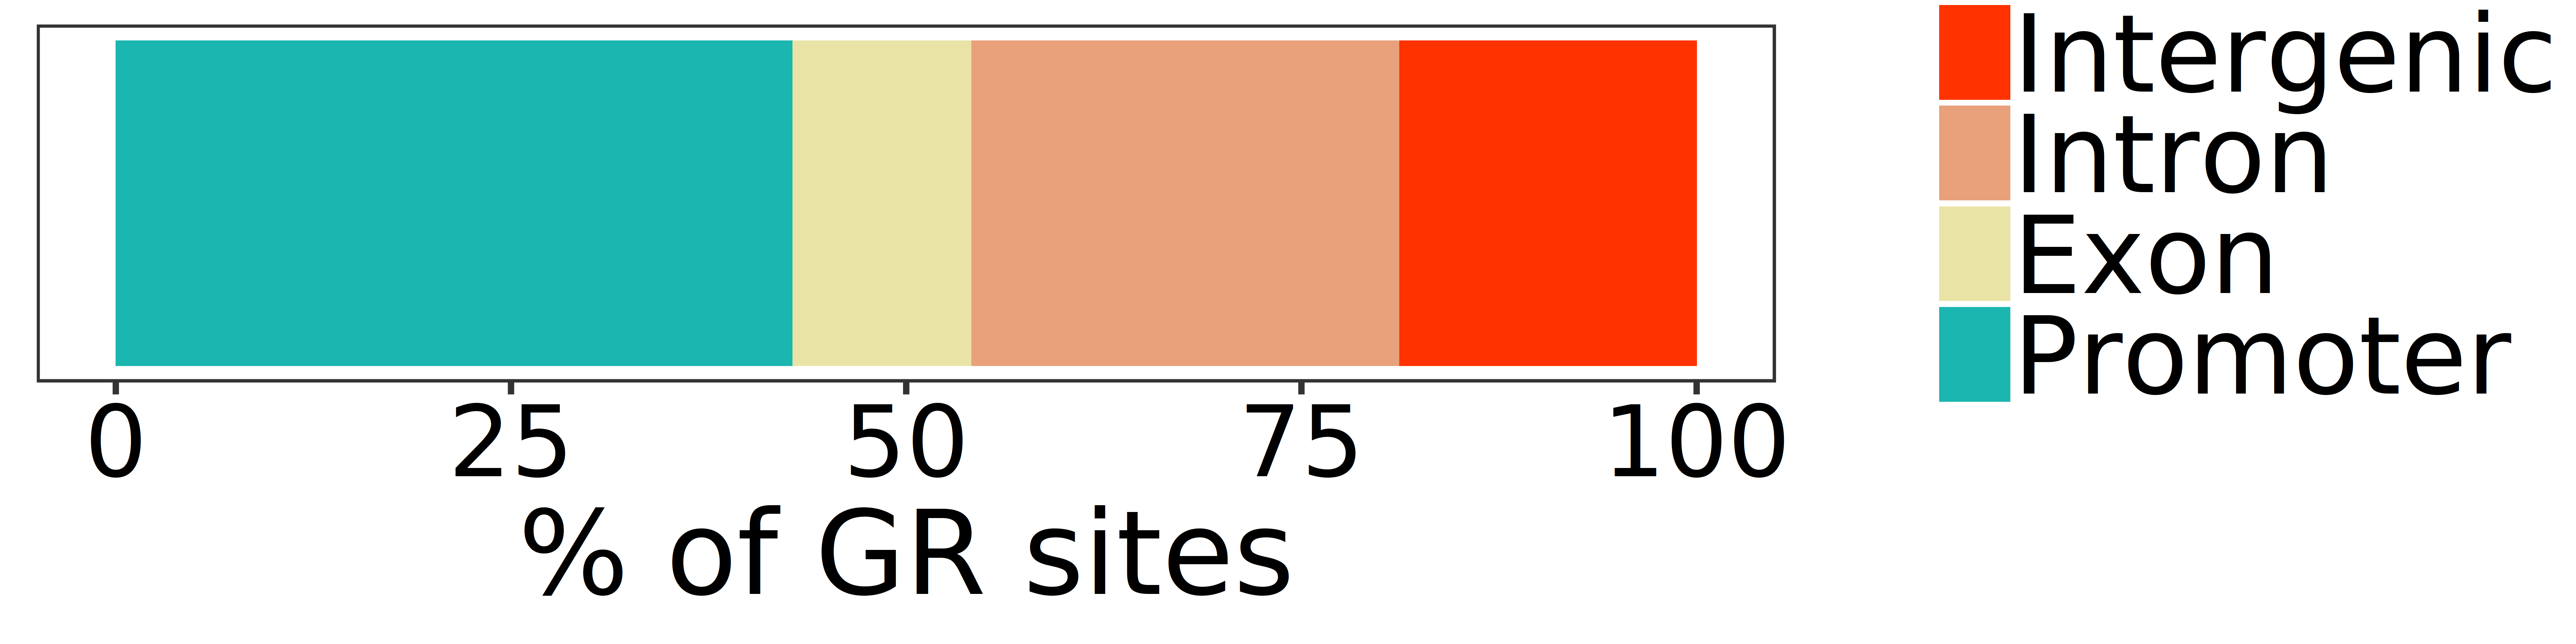

In [92]:
# Generate the plot
options(repr.plot.width=8, repr.plot.height=2,repr.plot.res=900)
ggplot(data = anno_df, aes(x = x, y = V1, fill=anno)) +
  geom_bar(stat="identity",width=0.5) + theme_bw() + theme(axis.title.y=element_blank(),
                                                           panel.grid.major = element_blank(),
                                                          panel.grid.minor = element_blank(),
                                                     axis.text.y=element_blank(),
                                                      axis.ticks.y=element_blank(),
                                                     axis.title.x=element_text(size=26,color='black'),
                                                      legend.title = element_blank(),
                                                      legend.position='right',
                                                           legend.margin=margin(0,0,0,25),
                                                      legend.text = element_text(size=24,color='black',margin=margin(0,15,0,0)),
                                                      axis.text.x=element_text(size=22,color='black')) +
ylab('% of GR sites') + scale_fill_manual(values = as.vector(paletteer::paletteer_d("LaCroixColoR::PeachPear")[1:4])) +
guides(fill = guide_legend(nrow = 4)) + coord_flip()

In [71]:
# Generate granges objects
peakAnno_df <- as.data.frame(peakAnno)

prom_gr <- GRanges(
  seqnames = peakAnno_df[peakAnno_df$annotation == 'Promoter','seqnames'],  
  ranges = IRanges(start = peakAnno_df[peakAnno_df$annotation == 'Promoter','start'], 
                   end = peakAnno_df[peakAnno_df$annotation == 'Promoter','end'])
)

nonprom_gr <- GRanges(
  seqnames = peakAnno_df[peakAnno_df$annotation != 'Promoter','seqnames'],  
  ranges = IRanges(start = peakAnno_df[peakAnno_df$annotation != 'Promoter','start'], 
                   end = peakAnno_df[peakAnno_df$annotation != 'Promoter','end'])
)

In [72]:
# Export promoter vs. non-promoter sites for motif analysis
# Export as BED file
rtracklayer::export(prom_gr,
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_prom_sites.col.bed',
                    format = 'BED')

rtracklayer::export(nonprom_gr,
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_nonprom_sites.col.bed',
                    format = 'BED')

# Overlap astrocyte GR peaks with GR-dependent ATAC peaks

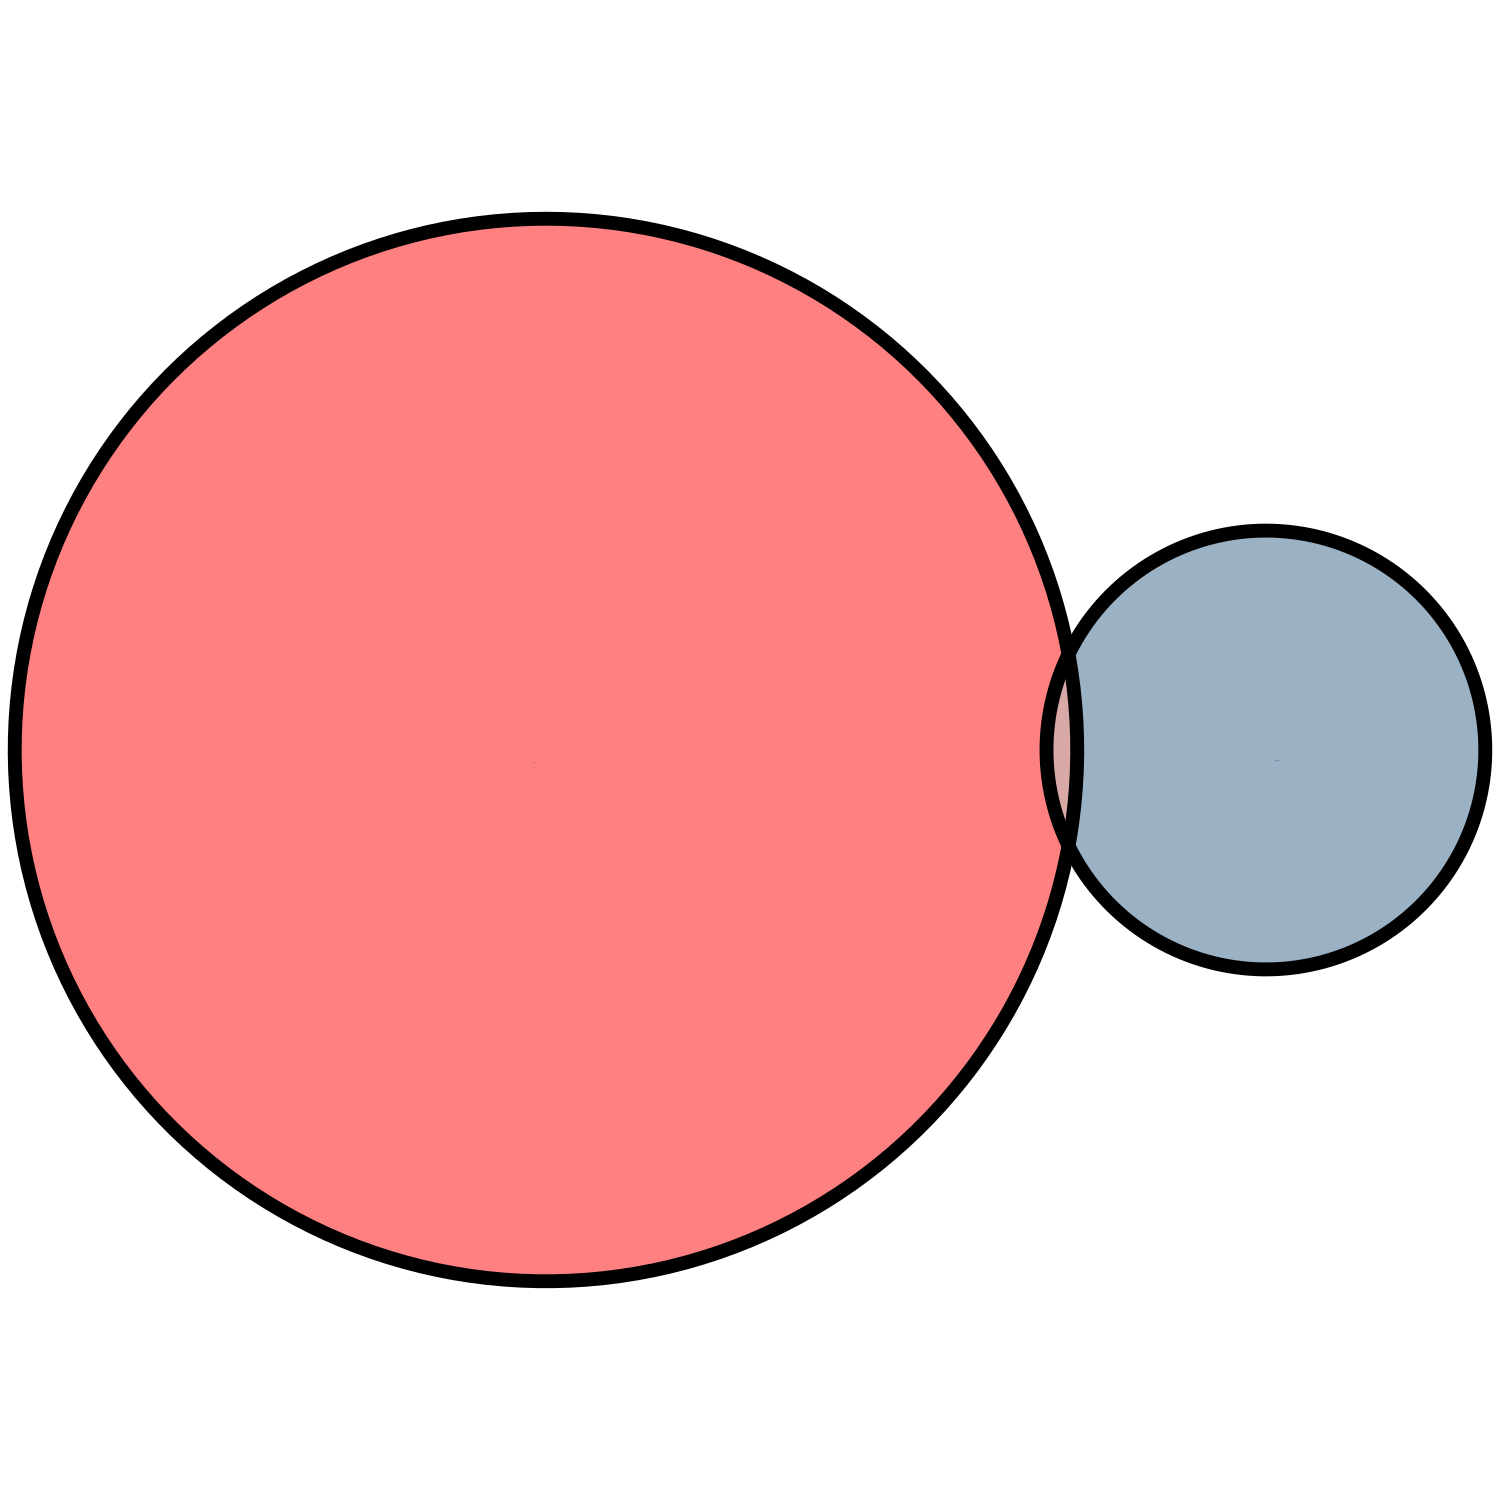

In [4]:
## Import overlaps from bedtools intersect
# Generate plots
DEG_overlap <- c(
  'GR' = 6246,
  'ATAC-Up' = 1042,
  "GR&ATAC-Up" =28
)

options(repr.plot.width=3, repr.plot.height=3,repr.plot.res=500)
fit3 <- euler(DEG_overlap, shape = "ellipse")
plot(fit3,
     lwd=2,
    fills = list(fill = c("red", "steelblue4"), alpha = 0.5),
     labels = list(col = "black", fontsize = 0))

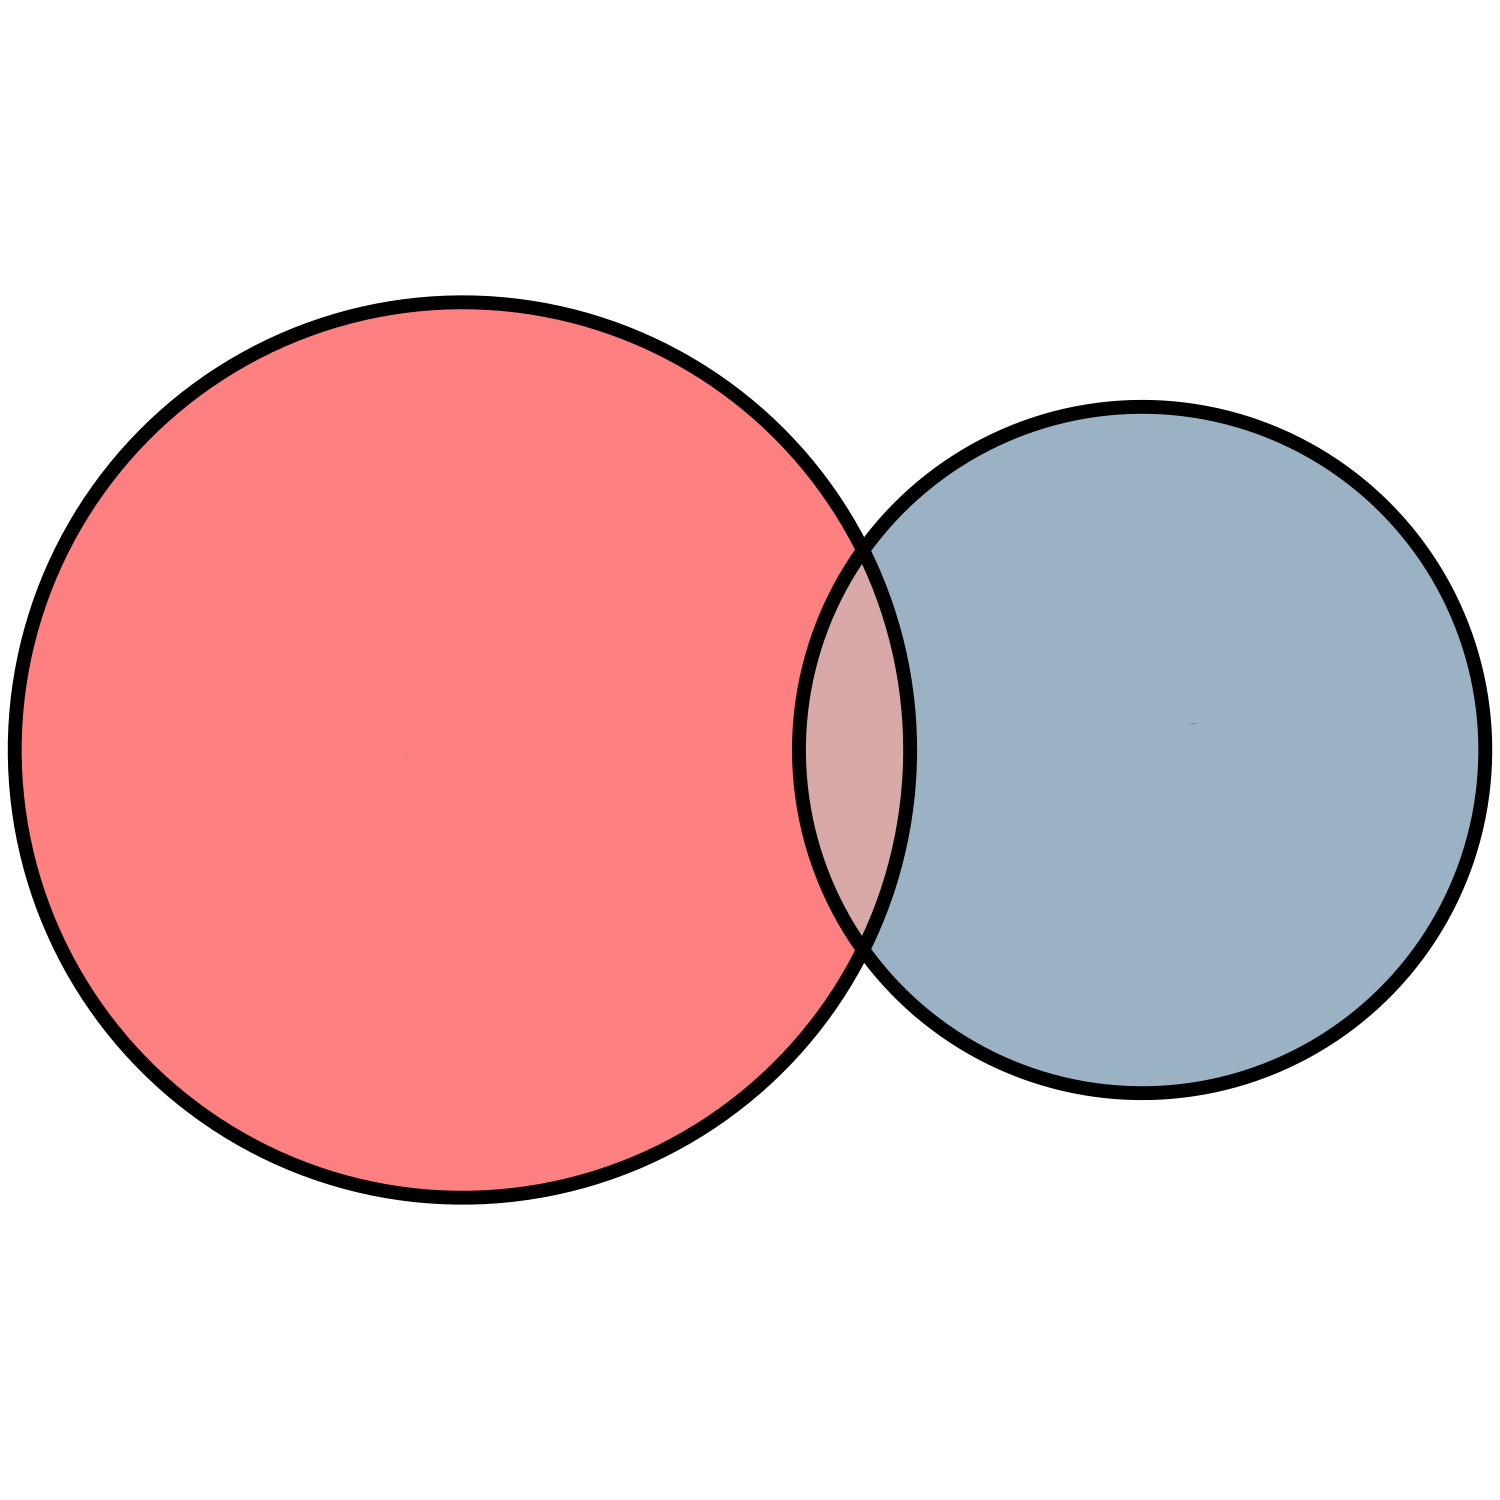

In [5]:
# Generate plots
DEG_overlap <- c(
  'GR' = 5974,
  'ATAC-Down' = 3386,
  "GR&ATAC-Down" = 300
)

options(repr.plot.width=3, repr.plot.height=3,repr.plot.res=500)
fit3 <- euler(DEG_overlap, shape = "ellipse")
plot(fit3,
     lwd=2,
    fills = list(fill = c("red", "steelblue4"), alpha = 0.5),
     labels = list(col = "black", fontsize = 0))

# Plot number of overlaps with GR ChIP datasets collected from other mouse tissues

In [124]:
# Read in GR CUT&RUN/ChIP-seq overlaps (from bedtools intersect)
GR_tissue_overlap <- read.csv('/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_count_edger_report_str_FC25_tissue_overlaps.bed',sep='\t',header=FALSE)

In [125]:
GR_tissue_overlap$peakID <- paste0(GR_tissue_overlap$V1,'-',GR_tissue_overlap$V2,'-',GR_tissue_overlap$V3)

In [126]:
# Count overlaps at each astrocyte GR site
compData <- data.frame(peakID= numeric(0), 
                       seqnames=numeric(0),
                       start=numeric(0),
                       end=numeric(0),
                       overlap=numeric(0))

for (i in unique(GR_tissue_overlap$peakID)){
    df <- data.frame(peakID = i, 
                       seqnames = GR_tissue_overlap[GR_tissue_overlap$peakID==i,'V1'][1],
                       start = GR_tissue_overlap[GR_tissue_overlap$peakID==i,'V2'][1],
                       end = GR_tissue_overlap[GR_tissue_overlap$peakID==i,'V3'][1],
                       overlap = sum(GR_tissue_overlap[GR_tissue_overlap$peakID==i,'V8'] > 0))
    compData <- rbind(compData,df)
}


In [51]:
# Export astrocyte-specific sites as a new bed file
write.table(compData[compData$overlap == 0,2:4], '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/CR01_count_edger_report_str_FC25_astro_specific.bed',
          sep='\t', quote=FALSE, row.names=FALSE, col.names=FALSE)

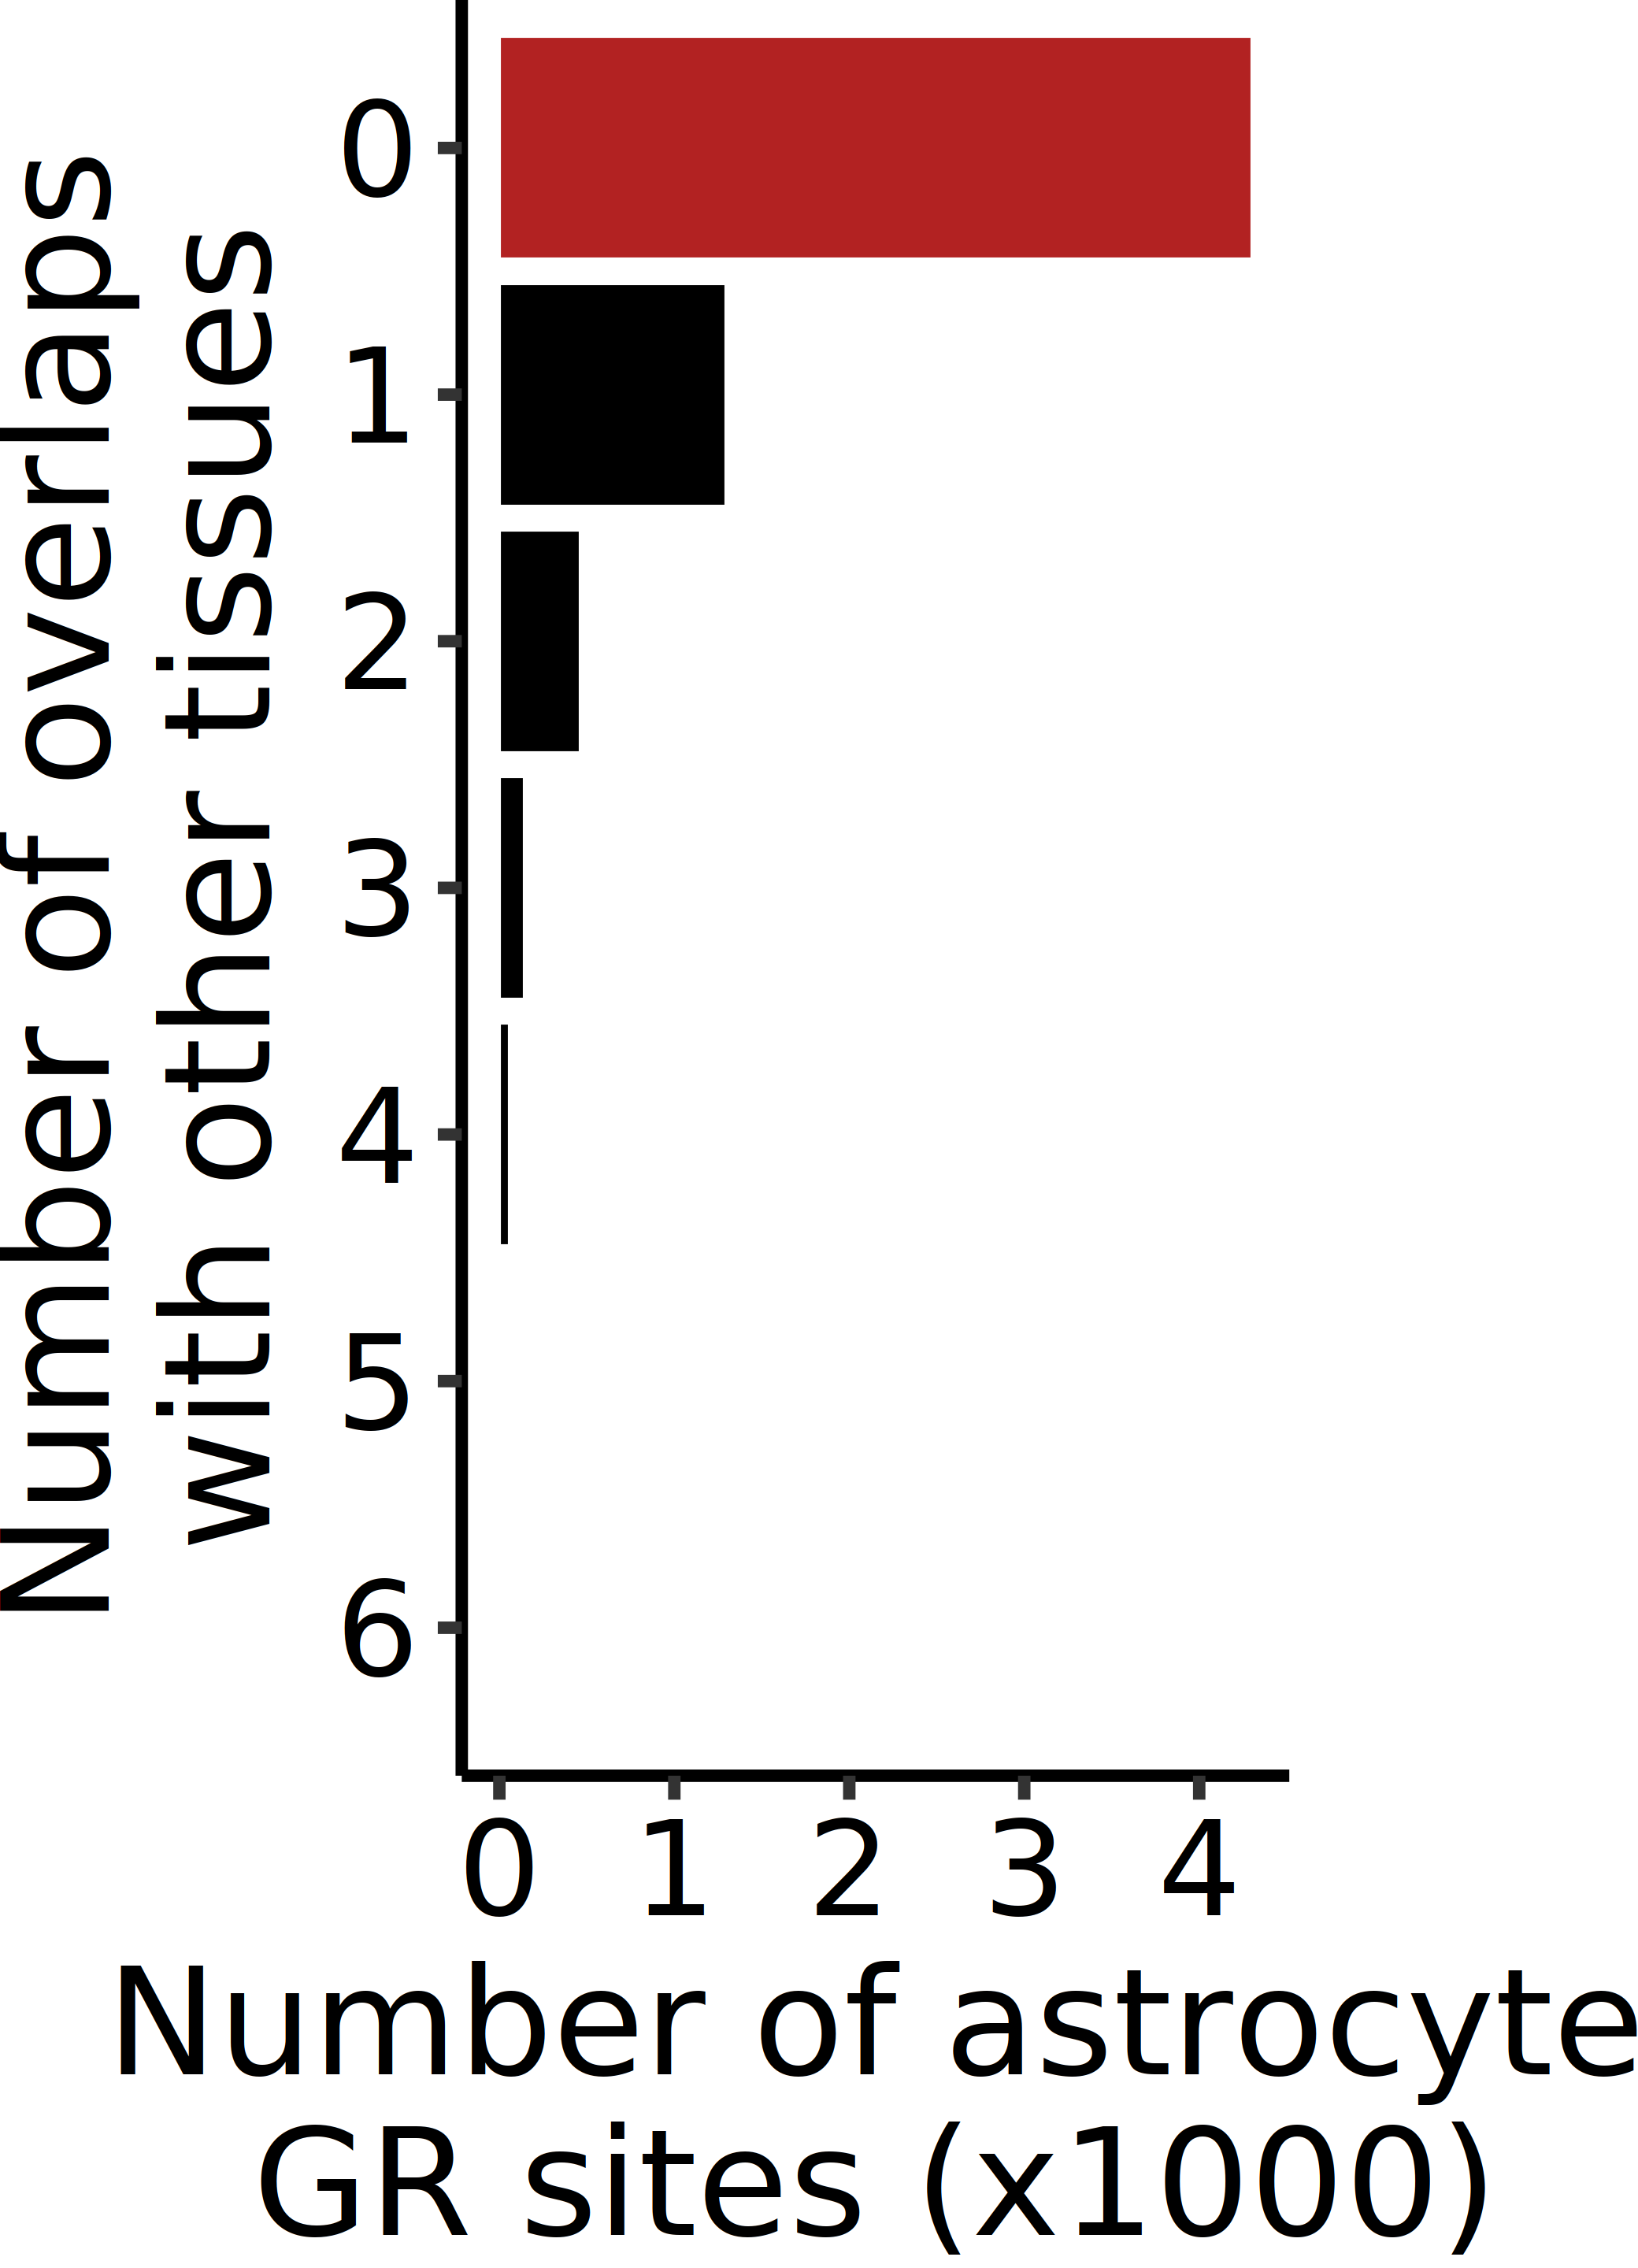

In [131]:
# Generate plot of GR binding overlaps with other tissues
options(repr.plot.width=2.6, repr.plot.height=3.6,repr.plot.res=800)
compData$overlap <- factor(compData$overlap,levels = rev(c(0,1,2,3,4,5,6)))
ggplot(compData, aes(x=overlap)) + 
  geom_bar(color="white",fill= c(rep('black',6),'firebrick'), size=0.1) + theme_classic() + theme(axis.text = element_text(size=15,color='black'),
                                                                 axis.title = element_text(size=17,color='black'),
                                                                 plot.margin = margin(0,40,0,0),
                                                                 axis.title.y=element_text(margin=margin(0,5,0,0))) + 
xlab('Number of overlaps\nwith other tissues') +
scale_y_continuous(name = 'Number of astrocyte\nGR sites (x1000)',labels = function(x) x / 1000) +
coord_flip()

# Generate example DR vs. NR GR binding tracks

In [3]:
# Import bigwig files
fp_list <- list(DR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_DR_IgG_R1.bw',
                NR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_NR_IgG_R1.bw',
                DR_GR =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_DR_GR_merge.bw',
                NR_GR =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_NR_GR_merge.bw',
                GR_Con = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/delCre_pos_GR_merge.bw',
                GR_KO =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/Cre_pos_GR_merge.bw')

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"


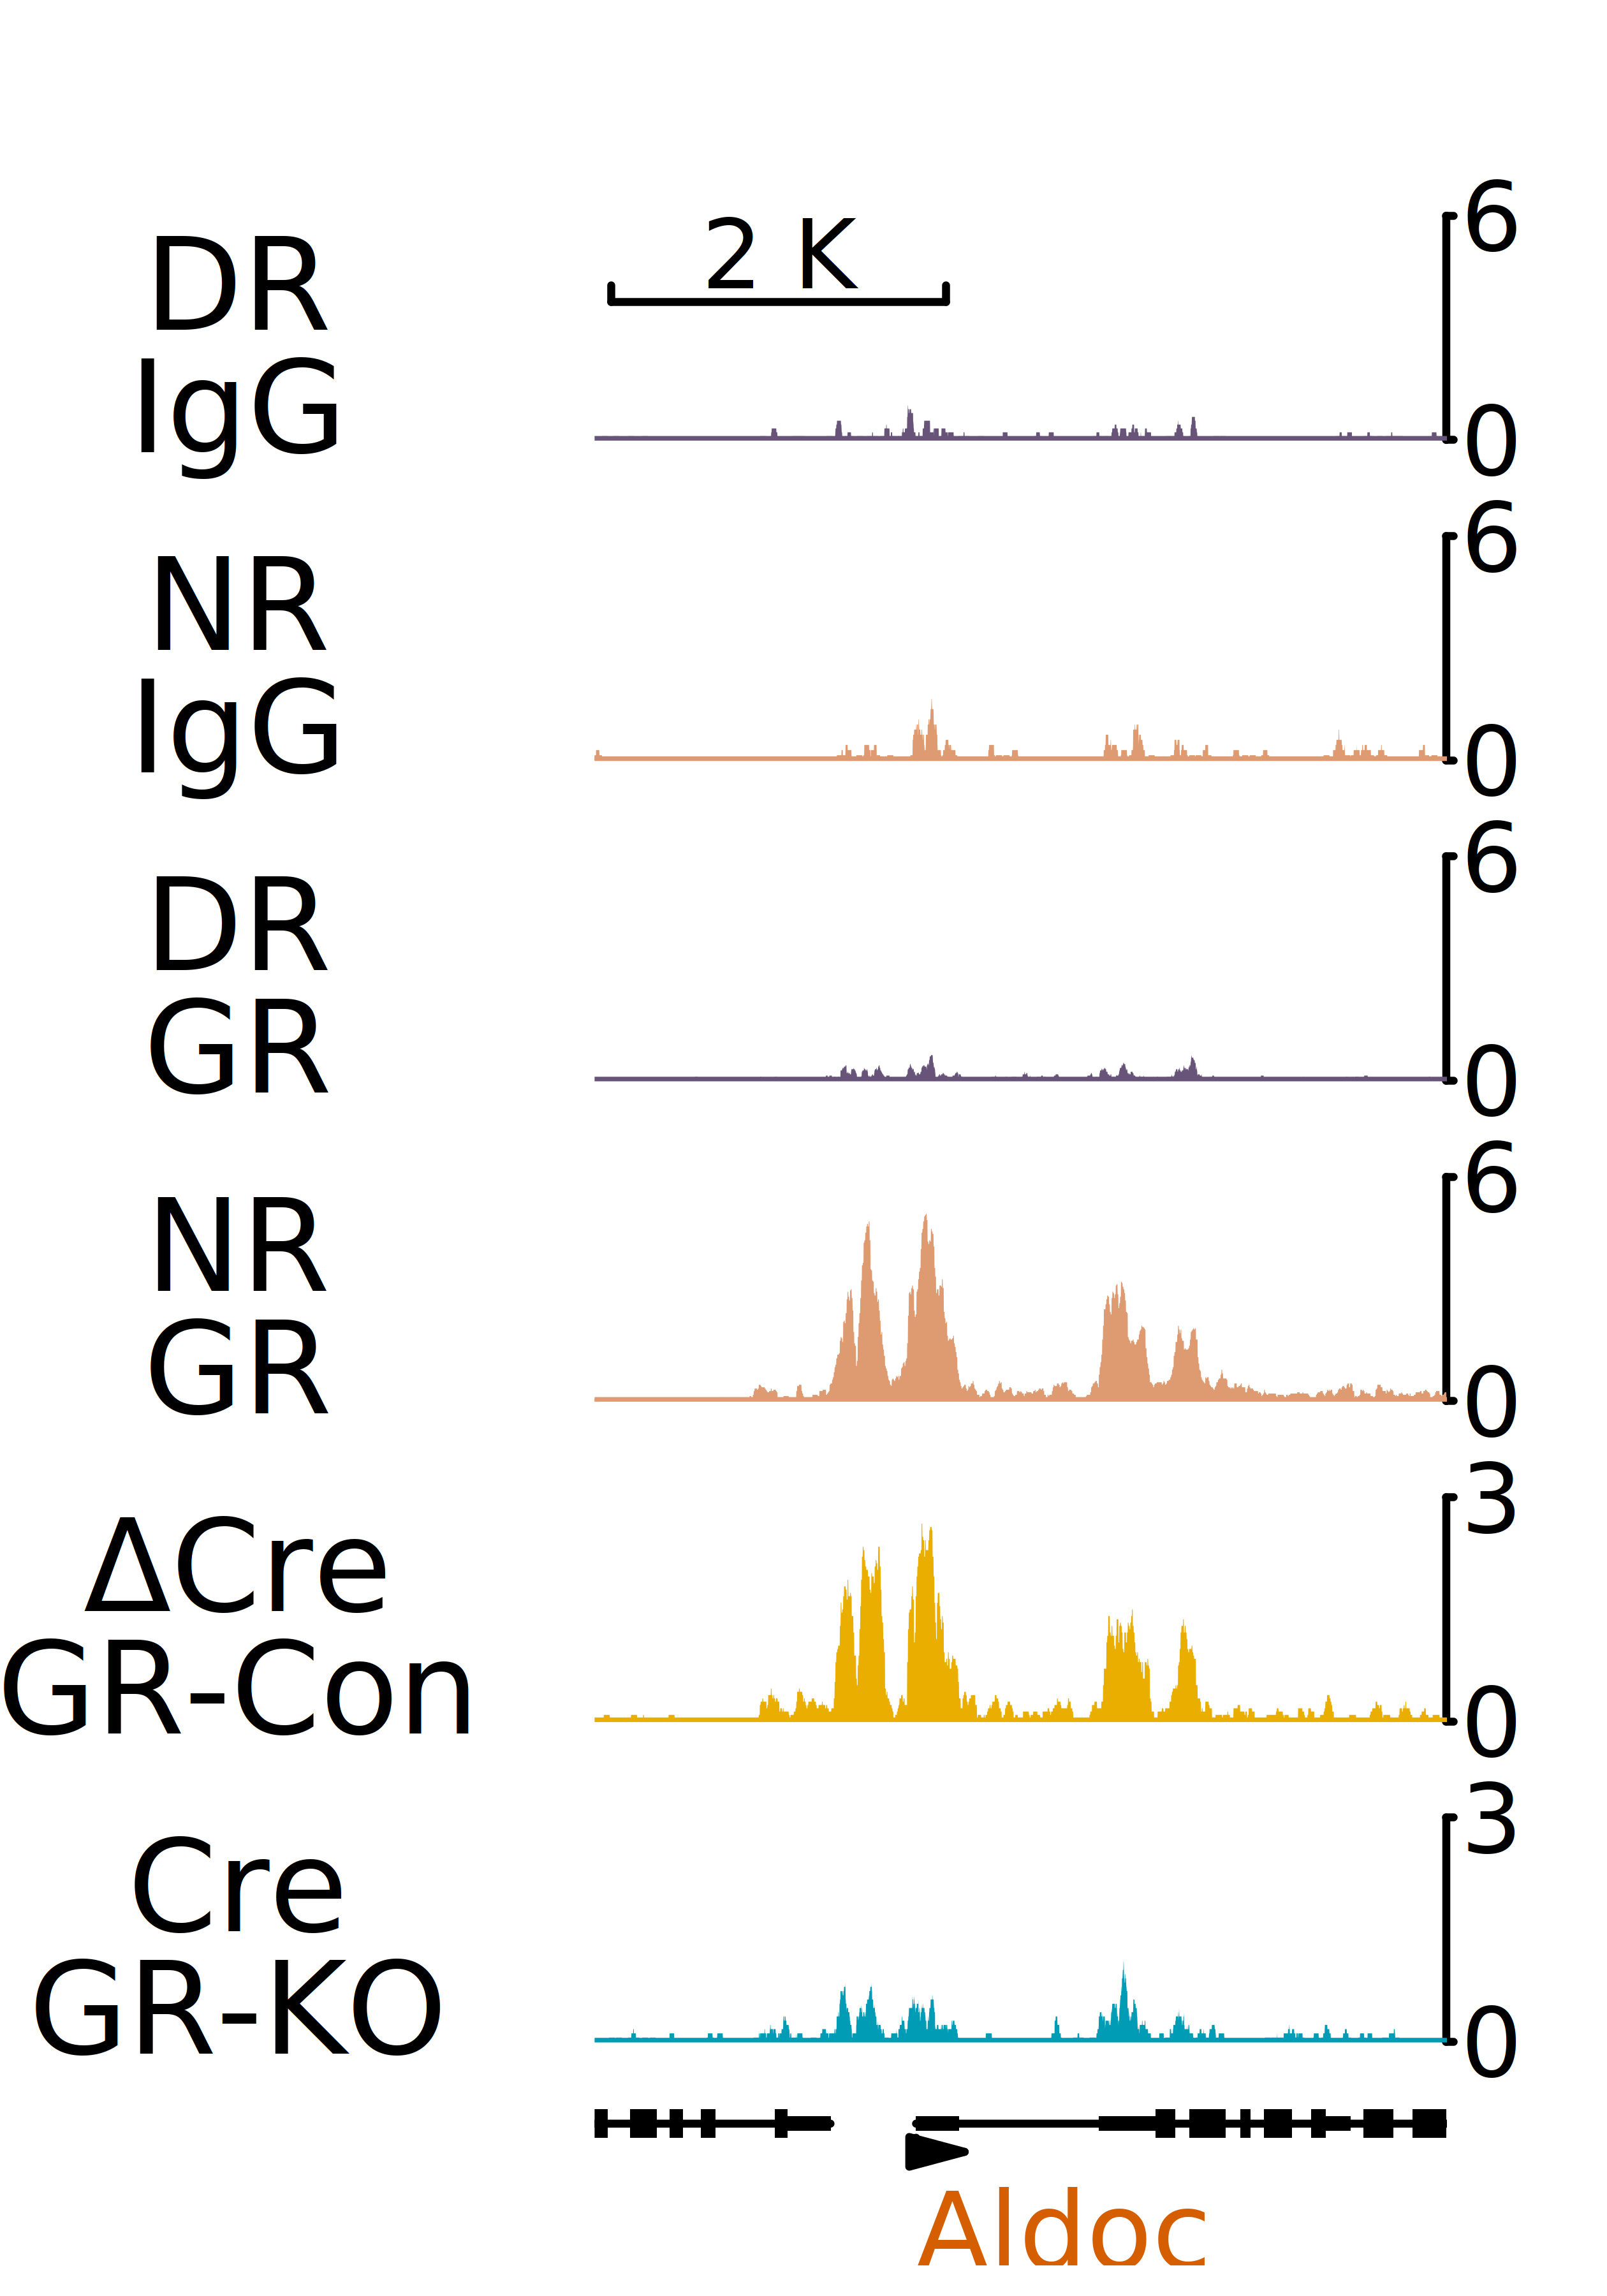

In [19]:
# Generate Aldoc track
# Import score for Aldoc locus
gr <- GRanges("chr11", IRanges(78321048,78326135))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('DR\nIgG',
                          'NR\nIgG',
                          'DR\nGR',
                          'NR\nGR',
                          'ΔCre\nGR-Con',
                          'Cre\nGR-KO',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Con_color <- "#EAAE00"
KO_color <- "#009CB5"

options(repr.plot.width=2.8, repr.plot.height=4,repr.plot.res=900)
setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(.01, 0.37, .08, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[7]], "draw", TRUE)
setTrackXscaleParam(trackList[[7]], attr="position", 
                    value=list(x=start(gr)+1100, y=3.7, label=2000))
setTrackXscaleParam(trackList[[7]], "gp", list(size=6,lineheight=0.1))


setTrackStyleParam(trackList[[2]], "ylim", c(0, 3.0))
setTrackStyleParam(trackList[[3]], "ylim", c(0, 3.0))
setTrackStyleParam(trackList[[4]], "ylim", c(0, 6.0))
setTrackStyleParam(trackList[[5]], "ylim", c(0, 6.0))
setTrackStyleParam(trackList[[6]], "ylim", c(0, 6.0))
setTrackStyleParam(trackList[[7]], "ylim", c(0, 6.0))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "color", "black")
setTrackStyleParam(trackList[[2]], "color", KO_color)
setTrackStyleParam(trackList[[3]], "color", Con_color)
setTrackStyleParam(trackList[[4]], "color", NR_color)
setTrackStyleParam(trackList[[5]], "color", DR_color)
setTrackStyleParam(trackList[[6]], "color", NR_color)
setTrackStyleParam(trackList[[7]], "color", DR_color)

#setTrackStyleParam(trackList[[2]], "margin", "#009CB5")


setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

setTrackYaxisParam(trackList[[2]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[3]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[4]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[5]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[6]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[7]], "gp", list(lineheight=0.15))

setTrackStyleParam(trackList[[2]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[3]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[4]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[5]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[6]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[7]], "ylabgp", list(lineheight=0.8,fontsize=16))

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



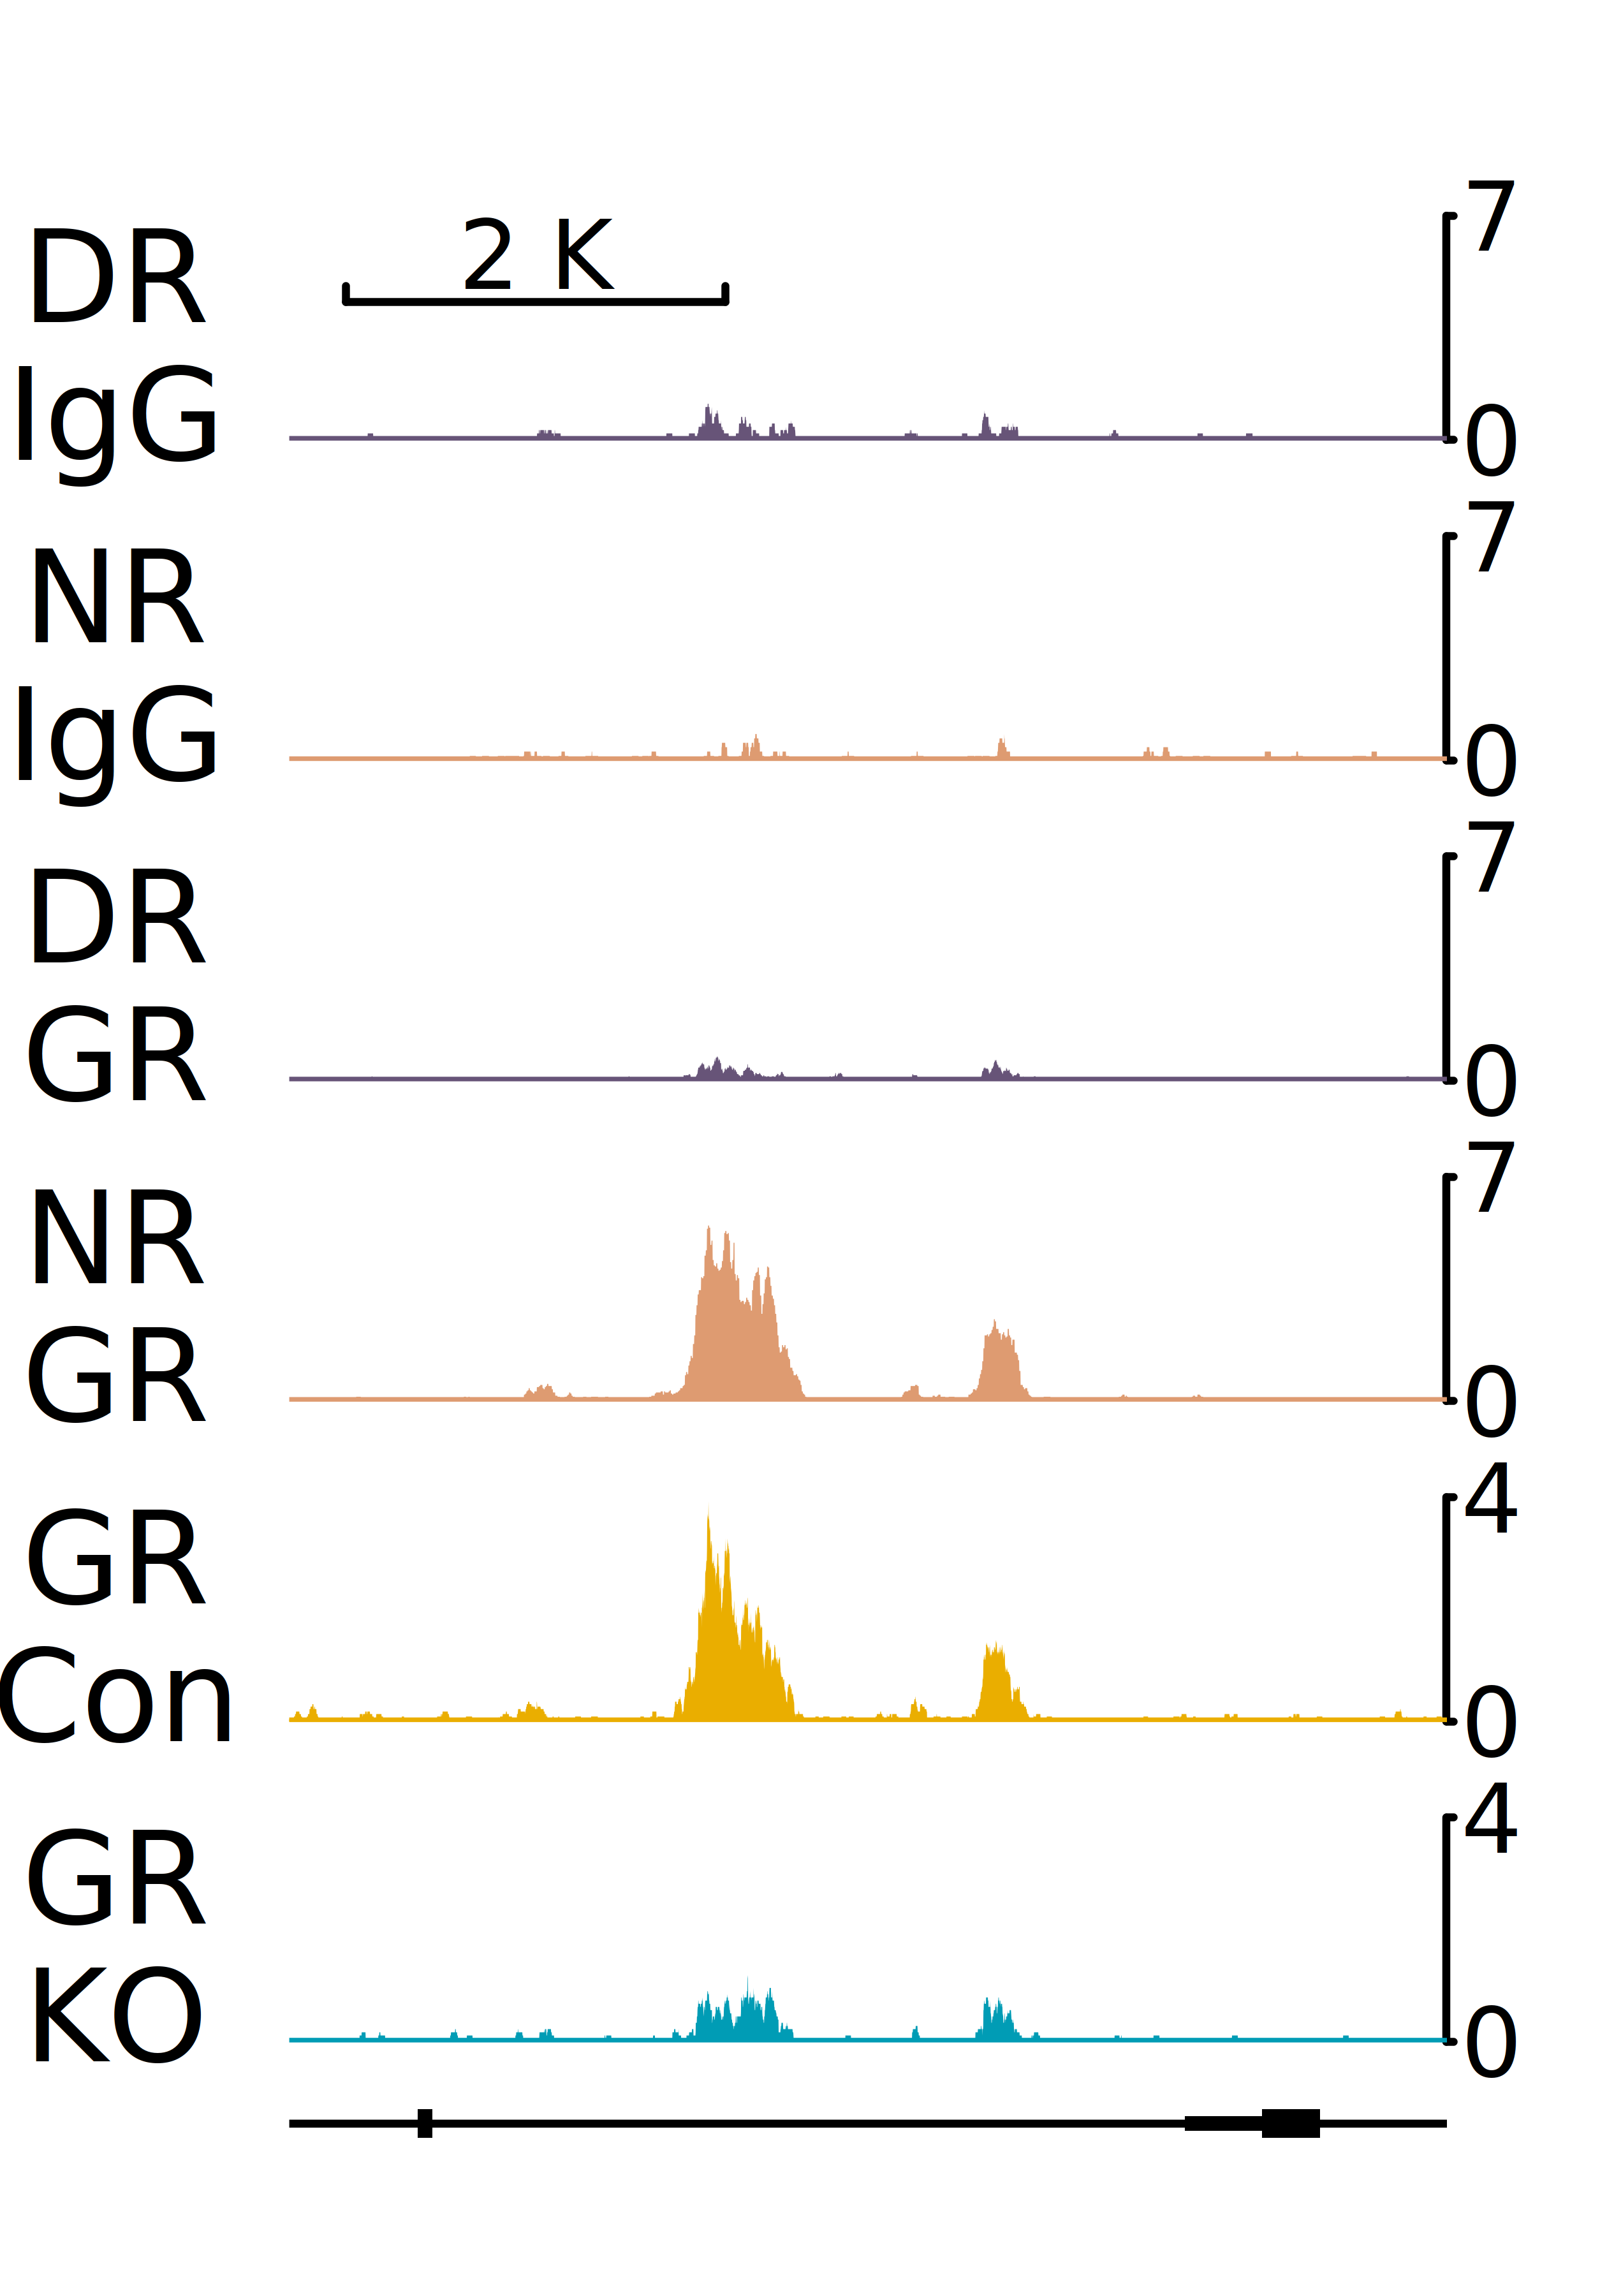

In [12]:
# Generate Nrxn2 track
# Import score for Nrxn2 locus
gr <- GRanges("chr19", IRanges(6449847,6455949))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('DR\nIgG',
                          'NR\nIgG',
                          'DR\nGR',
                          'NR\nGR',
                          'GR\nCon',
                          'GR\nKO',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Con_color <- "#EAAE00"
KO_color <- "#009CB5"

options(repr.plot.width=2.8, repr.plot.height=4,repr.plot.res=900)
setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(.01, 0.18, .08, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[7]], "draw", TRUE)
setTrackXscaleParam(trackList[[7]], attr="position", 
                    value=list(x=start(gr)+1300, y=4.3, label=2000))
setTrackXscaleParam(trackList[[7]], "gp", list(size=6,lineheight=0.1))


setTrackStyleParam(trackList[[2]], "ylim", c(0, 4.0))
setTrackStyleParam(trackList[[3]], "ylim", c(0, 4.0))
setTrackStyleParam(trackList[[4]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[5]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[6]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[7]], "ylim", c(0, 7.0))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "color", "black")
setTrackStyleParam(trackList[[2]], "color", KO_color)
setTrackStyleParam(trackList[[3]], "color", Con_color)
setTrackStyleParam(trackList[[4]], "color", NR_color)
setTrackStyleParam(trackList[[5]], "color", DR_color)
setTrackStyleParam(trackList[[6]], "color", NR_color)
setTrackStyleParam(trackList[[7]], "color", DR_color)

#setTrackStyleParam(trackList[[2]], "margin", "#009CB5")


setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

setTrackYaxisParam(trackList[[2]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[3]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[4]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[5]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[6]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[7]], "gp", list(lineheight=0.15))

setTrackStyleParam(trackList[[2]], "ylabgp", list(lineheight=0.9,fontsize=16))
setTrackStyleParam(trackList[[3]], "ylabgp", list(lineheight=0.9,fontsize=16))
setTrackStyleParam(trackList[[4]], "ylabgp", list(lineheight=0.9,fontsize=16))
setTrackStyleParam(trackList[[5]], "ylabgp", list(lineheight=0.9,fontsize=16))
setTrackStyleParam(trackList[[6]], "ylabgp", list(lineheight=0.9,fontsize=16))
setTrackStyleParam(trackList[[7]], "ylabgp", list(lineheight=0.9,fontsize=16))

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"


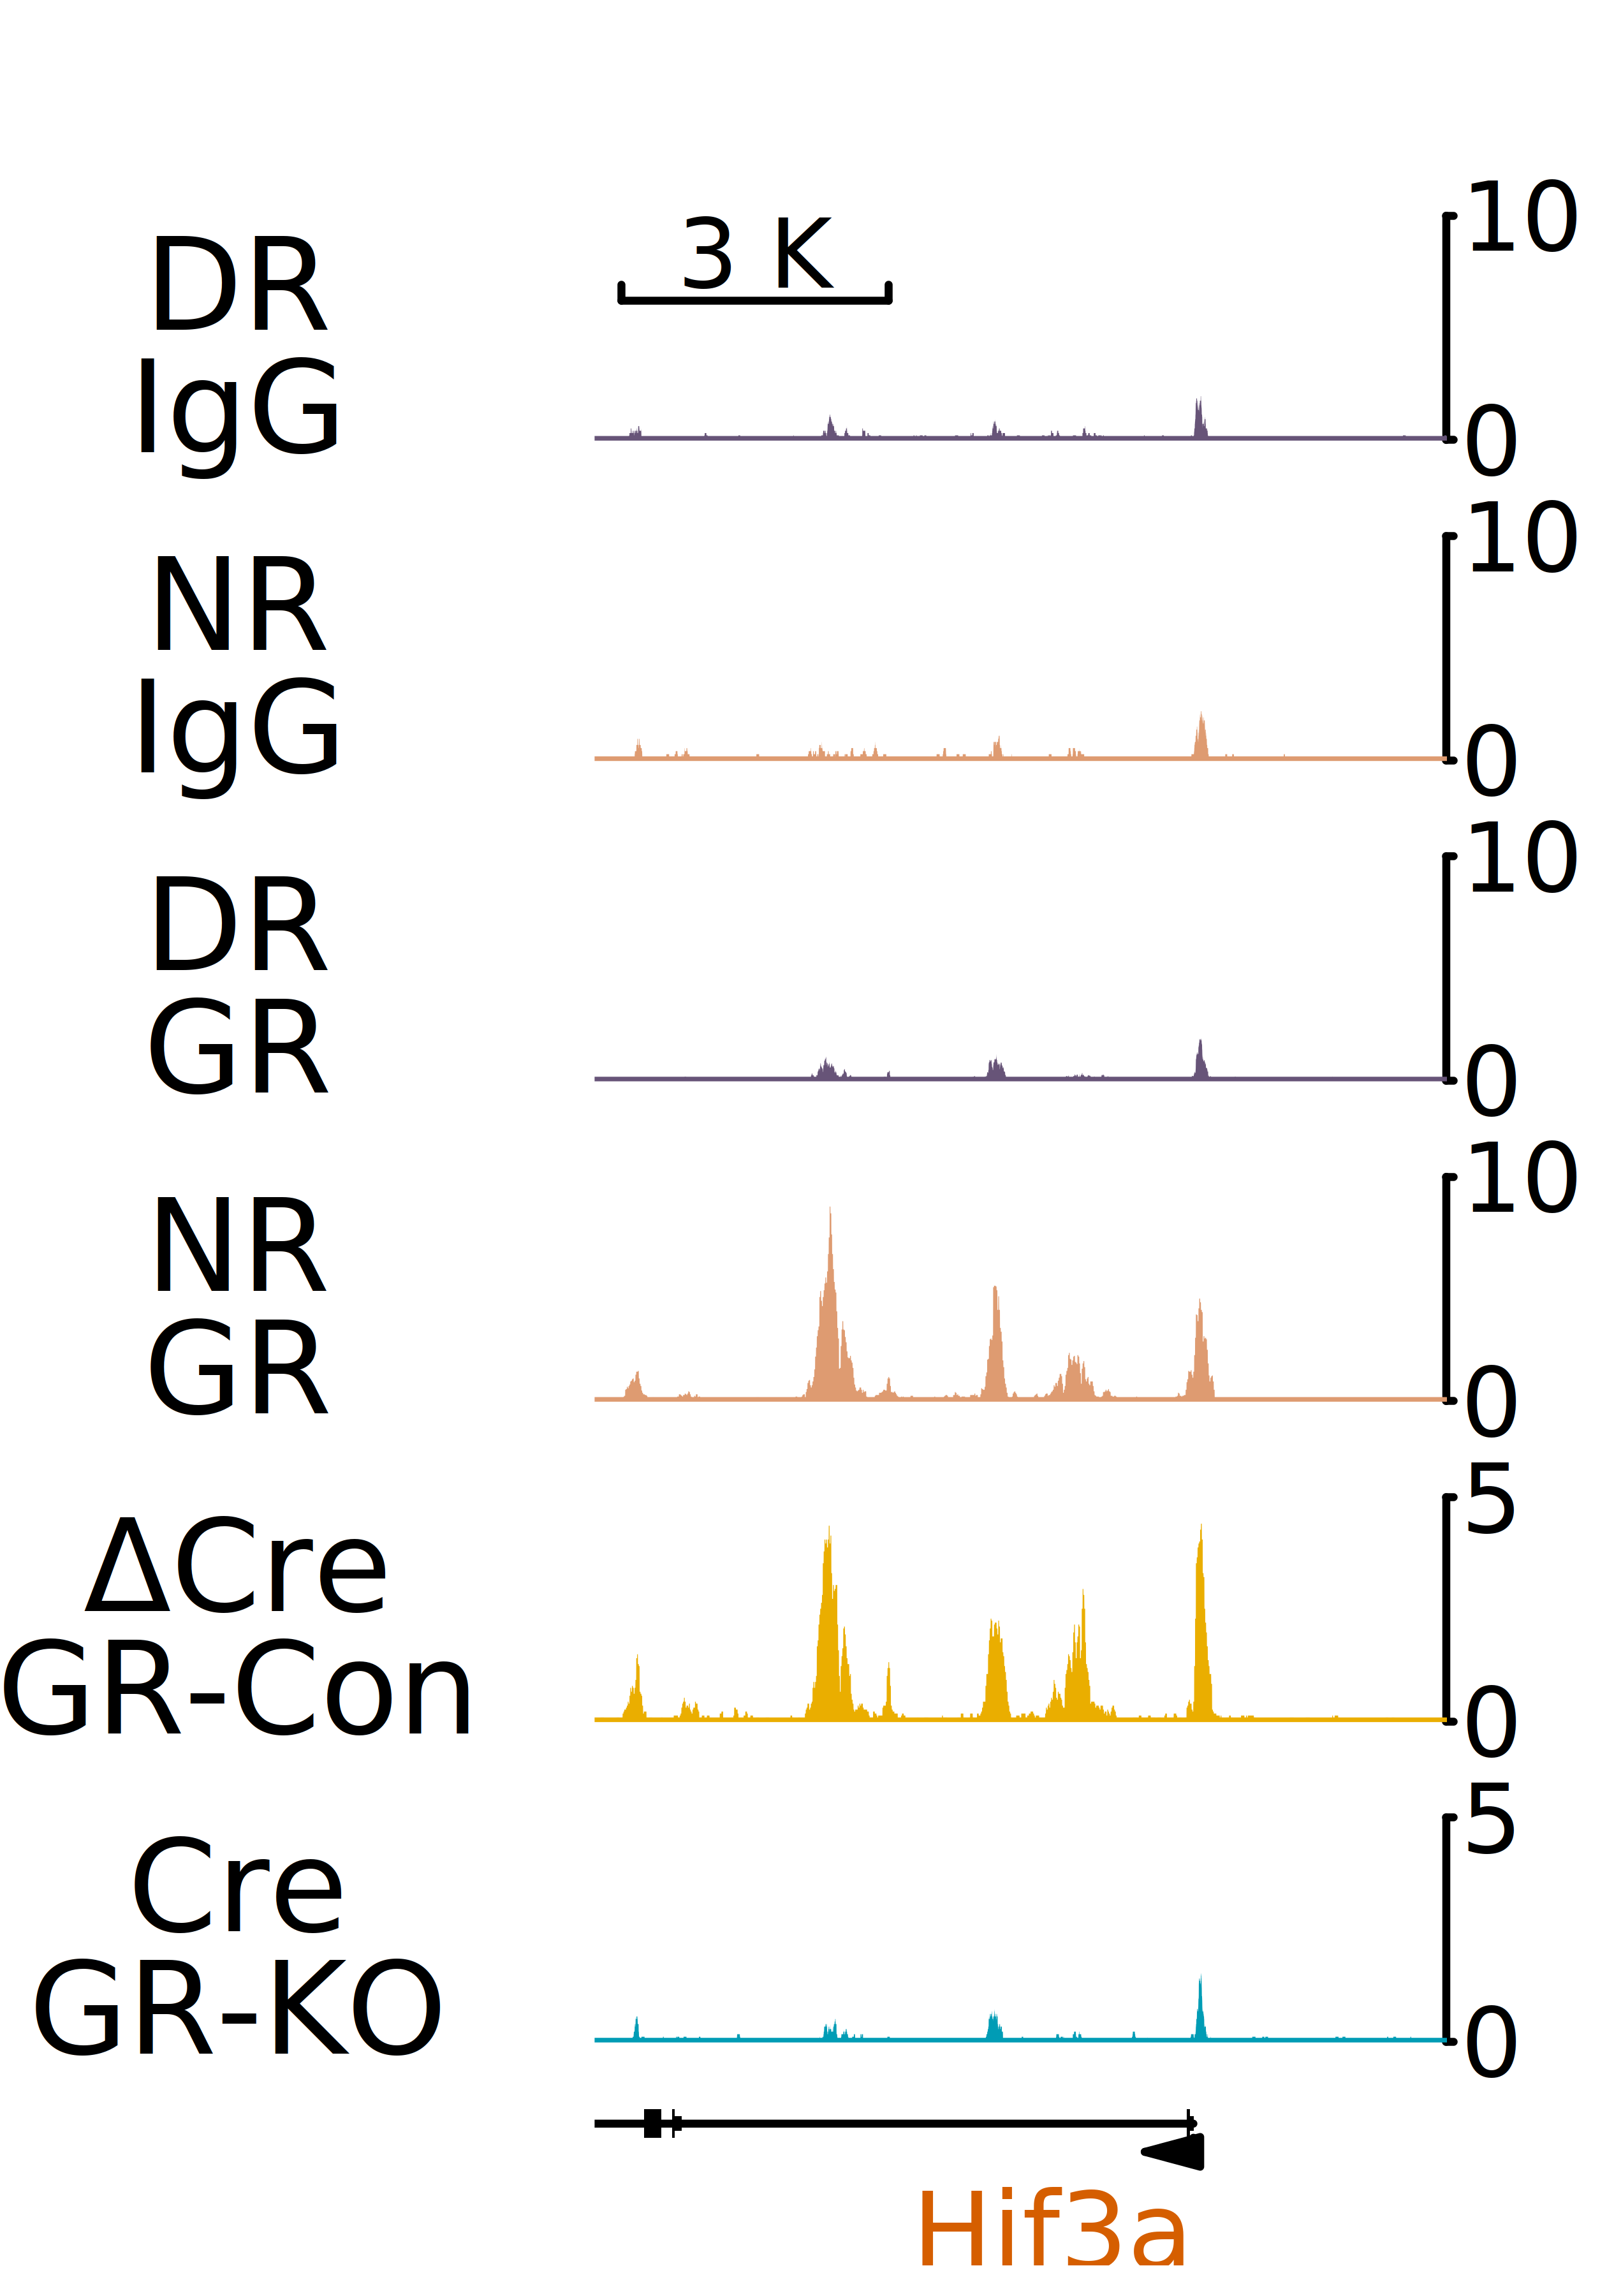

In [22]:
# Generate Hif3a track
gr <- GRanges("chr7", IRanges(17055702,17065267))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('DR\nIgG',
                          'NR\nIgG',
                          'DR\nGR',
                          'NR\nGR',
                          'ΔCre\nGR-Con',
                          'Cre\nGR-KO',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Con_color <- "#EAAE00"
KO_color <- "#009CB5"

options(repr.plot.width=2.8, repr.plot.height=4,repr.plot.res=900)
setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(.01, 0.37, .08, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[7]], "draw", TRUE)
setTrackXscaleParam(trackList[[7]], attr="position", 
                    value=list(x=start(gr)+1800, y=6.2, label=3000))
setTrackXscaleParam(trackList[[7]], "gp", list(size=6,lineheight=0.1))


setTrackStyleParam(trackList[[2]], "ylim", c(0, 5.0))
setTrackStyleParam(trackList[[3]], "ylim", c(0, 5.0))
setTrackStyleParam(trackList[[4]], "ylim", c(0, 10.0))
setTrackStyleParam(trackList[[5]], "ylim", c(0, 10.0))
setTrackStyleParam(trackList[[6]], "ylim", c(0, 10.0))
setTrackStyleParam(trackList[[7]], "ylim", c(0, 10.0))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "color", "black")
setTrackStyleParam(trackList[[2]], "color", KO_color)
setTrackStyleParam(trackList[[3]], "color", Con_color)
setTrackStyleParam(trackList[[4]], "color", NR_color)
setTrackStyleParam(trackList[[5]], "color", DR_color)
setTrackStyleParam(trackList[[6]], "color", NR_color)
setTrackStyleParam(trackList[[7]], "color", DR_color)

#setTrackStyleParam(trackList[[2]], "margin", "#009CB5")


setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

setTrackYaxisParam(trackList[[2]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[3]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[4]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[5]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[6]], "gp", list(lineheight=0.15))
setTrackYaxisParam(trackList[[7]], "gp", list(lineheight=0.15))

setTrackStyleParam(trackList[[2]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[3]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[4]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[5]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[6]], "ylabgp", list(lineheight=0.8,fontsize=16))
setTrackStyleParam(trackList[[7]], "ylabgp", list(lineheight=0.8,fontsize=16))

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

# Generate example astrocyte GR-Con vs. GR-KO GR binding tracks

In [23]:
# Import bigwigs
fp_list <- list(GR_Con_R1 = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/delCre_pos_R1_GR.bw',
                GR_KO_R1 =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/Cre_pos_R1_GR.bw',
                GR_Con_R2 =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/delCre_pos_R2_GR.bw',
                GR_KO_R2 =   '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_cre_delta/Cre_pos_R2_GR.bw')

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"


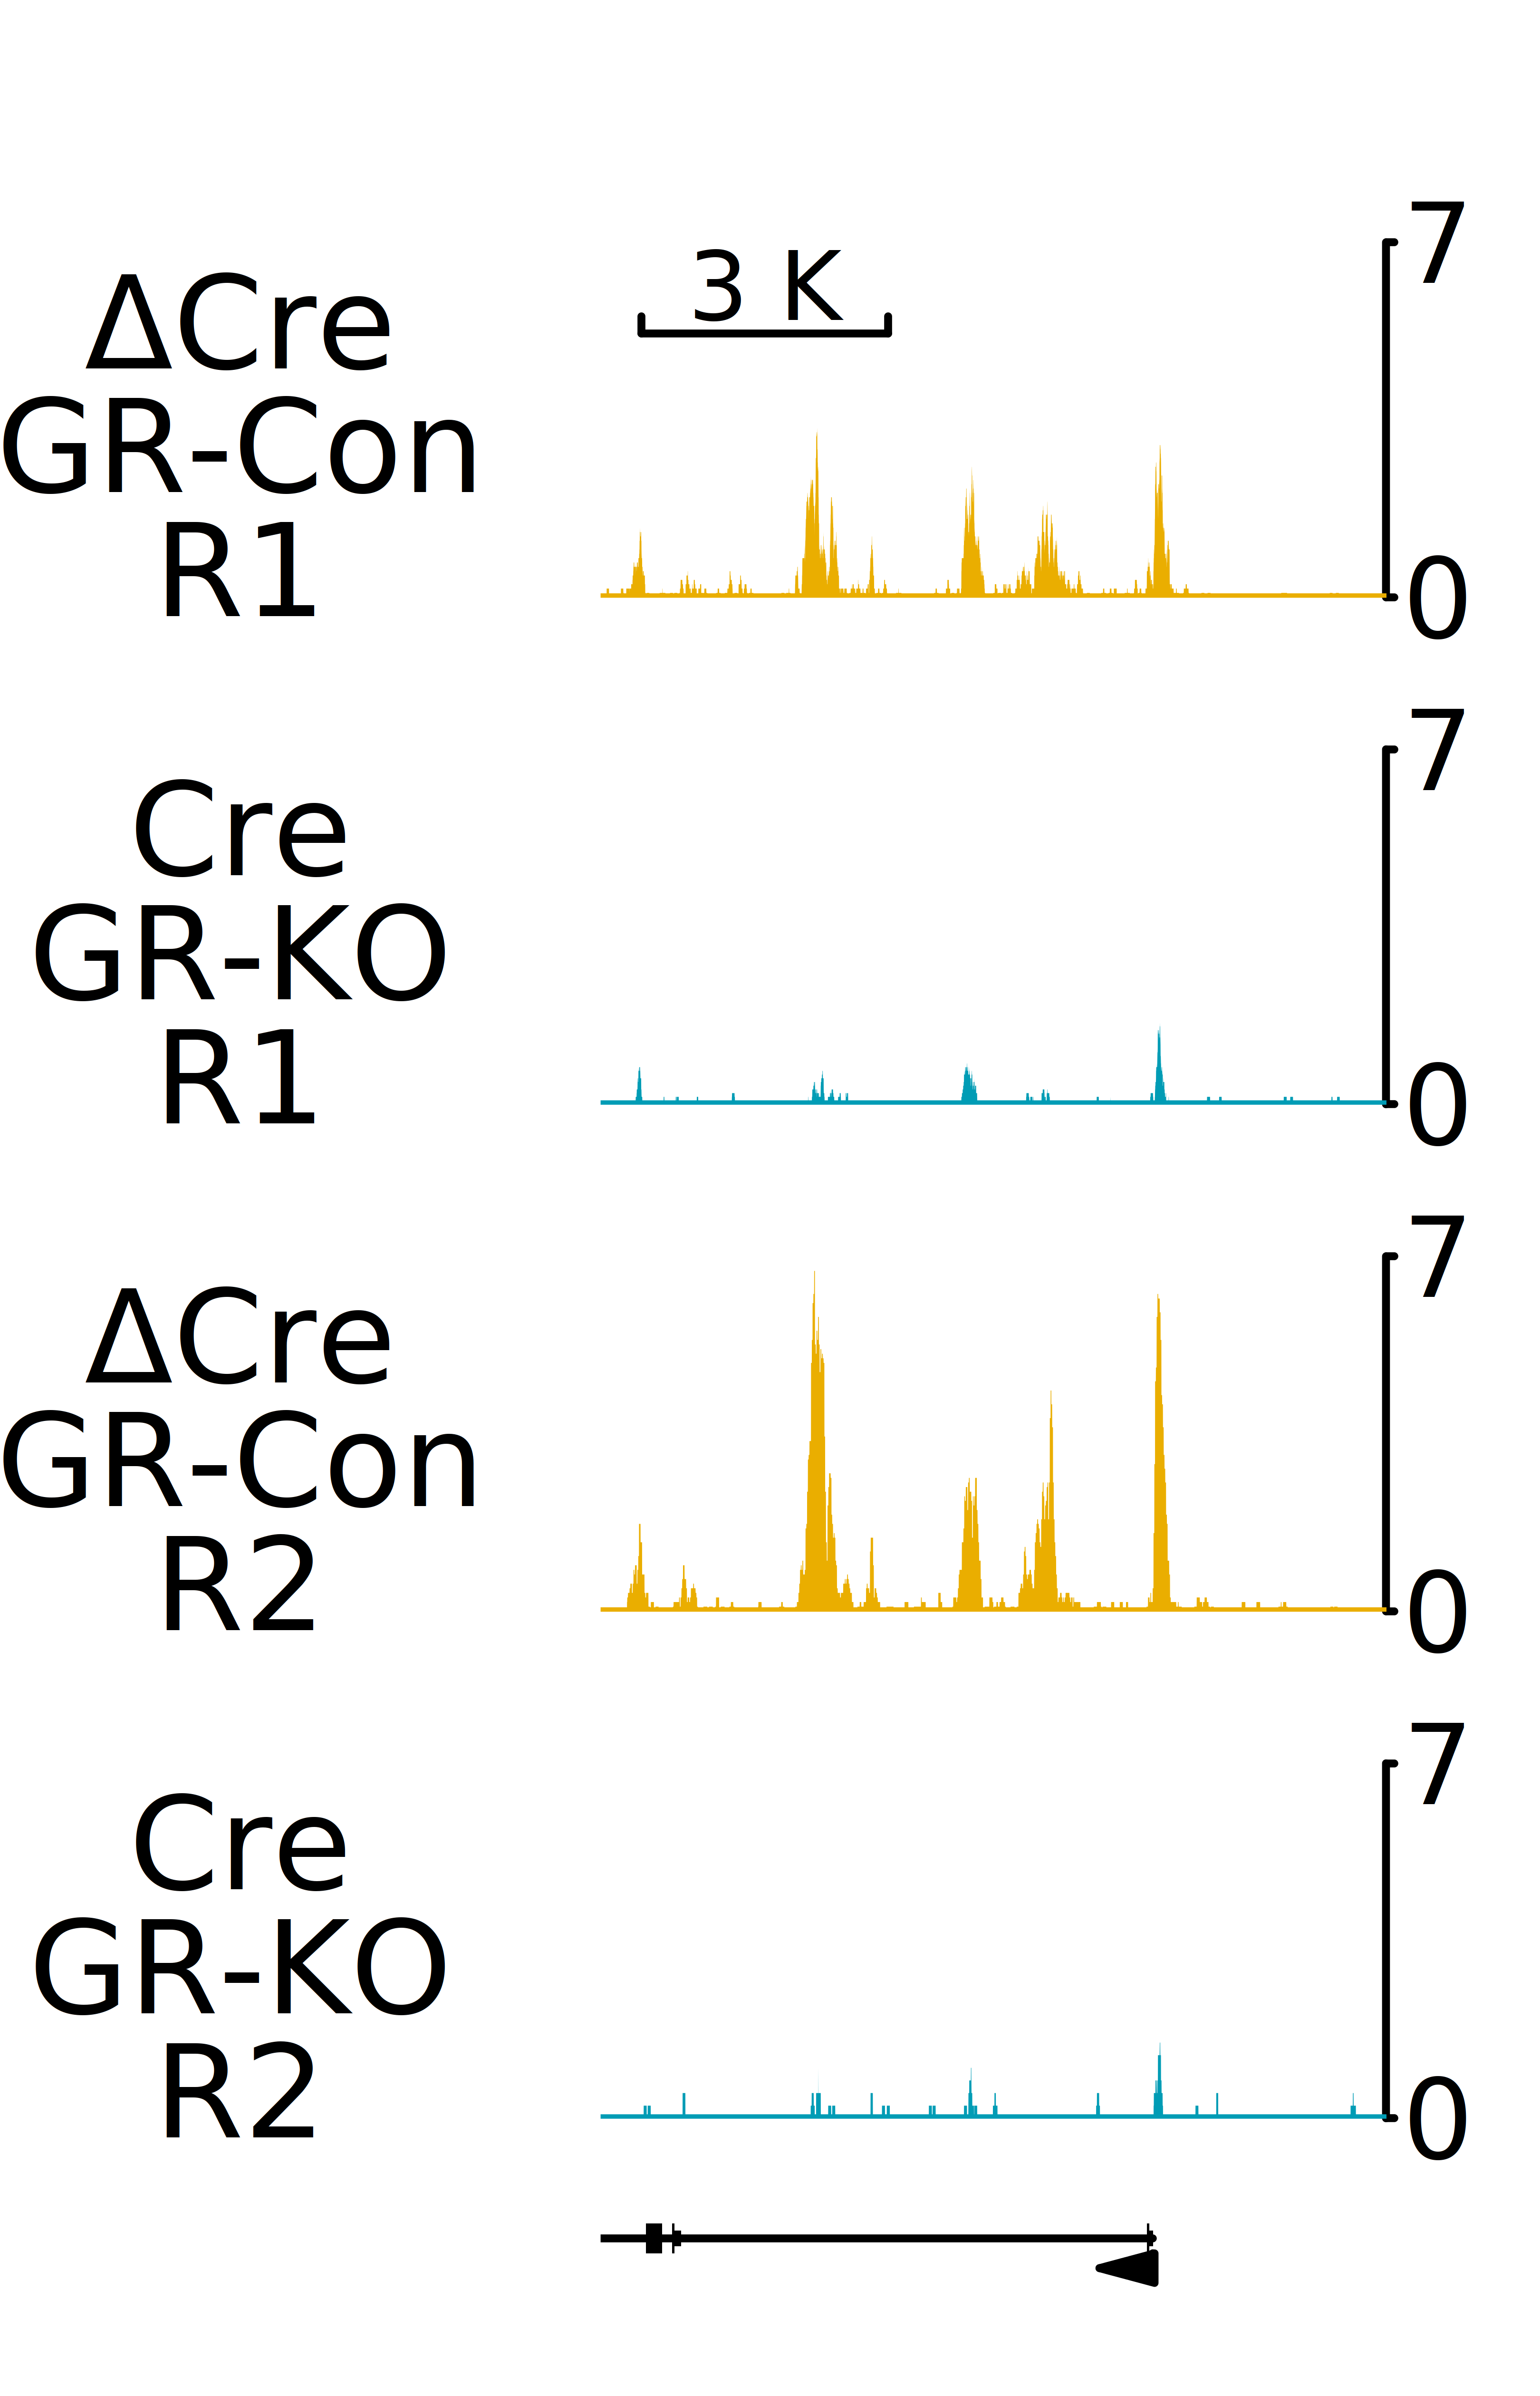

In [32]:
# Generate Hif3a track
gr <- GRanges("chr7", IRanges(17055702,17065267))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('ΔCre\nGR-Con\nR1',
                          'Cre\nGR-KO\nR1',
                          'ΔCre\nGR-Con\nR2',
                          'Cre\nGR-KO\nR2',''))

Con_color <- "#EAAE00"
KO_color <- "#009CB5"

options(repr.plot.width=1.8*1.5, repr.plot.height=2.8*1.5,repr.plot.res=1200)

setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(0, 0.39, .08, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[5]], "draw", TRUE)
setTrackXscaleParam(trackList[[5]], attr="position", 
                    value=list(x=start(gr)+2000, y=5.2, label=3000))
setTrackXscaleParam(trackList[[5]], "gp", list(size=6,lineheight=0.1))


setTrackStyleParam(trackList[[2]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[3]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[4]], "ylim", c(0, 7.0))
setTrackStyleParam(trackList[[5]], "ylim", c(0, 7.0))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "ylabgp", list(fontsize=0))
setTrackStyleParam(trackList[[1]], "color", 'black')

setTrackStyleParam(trackList[[2]], "color", KO_color)
setTrackStyleParam(trackList[[3]], "color", Con_color)
setTrackStyleParam(trackList[[4]], "color", KO_color)
setTrackStyleParam(trackList[[5]], "color", Con_color)

setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

setTrackYaxisParam(trackList[[2]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[3]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[4]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[5]], "gp", list(lineheight=0.15,fontsize=14))

setTrackStyleParam(trackList[[2]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[3]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[4]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[5]], "ylabgp", list(lineheight=0.8,fontsize=16.3))

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'ΔCre' in 'mbcsToSbcs': dot substituted for <94>"


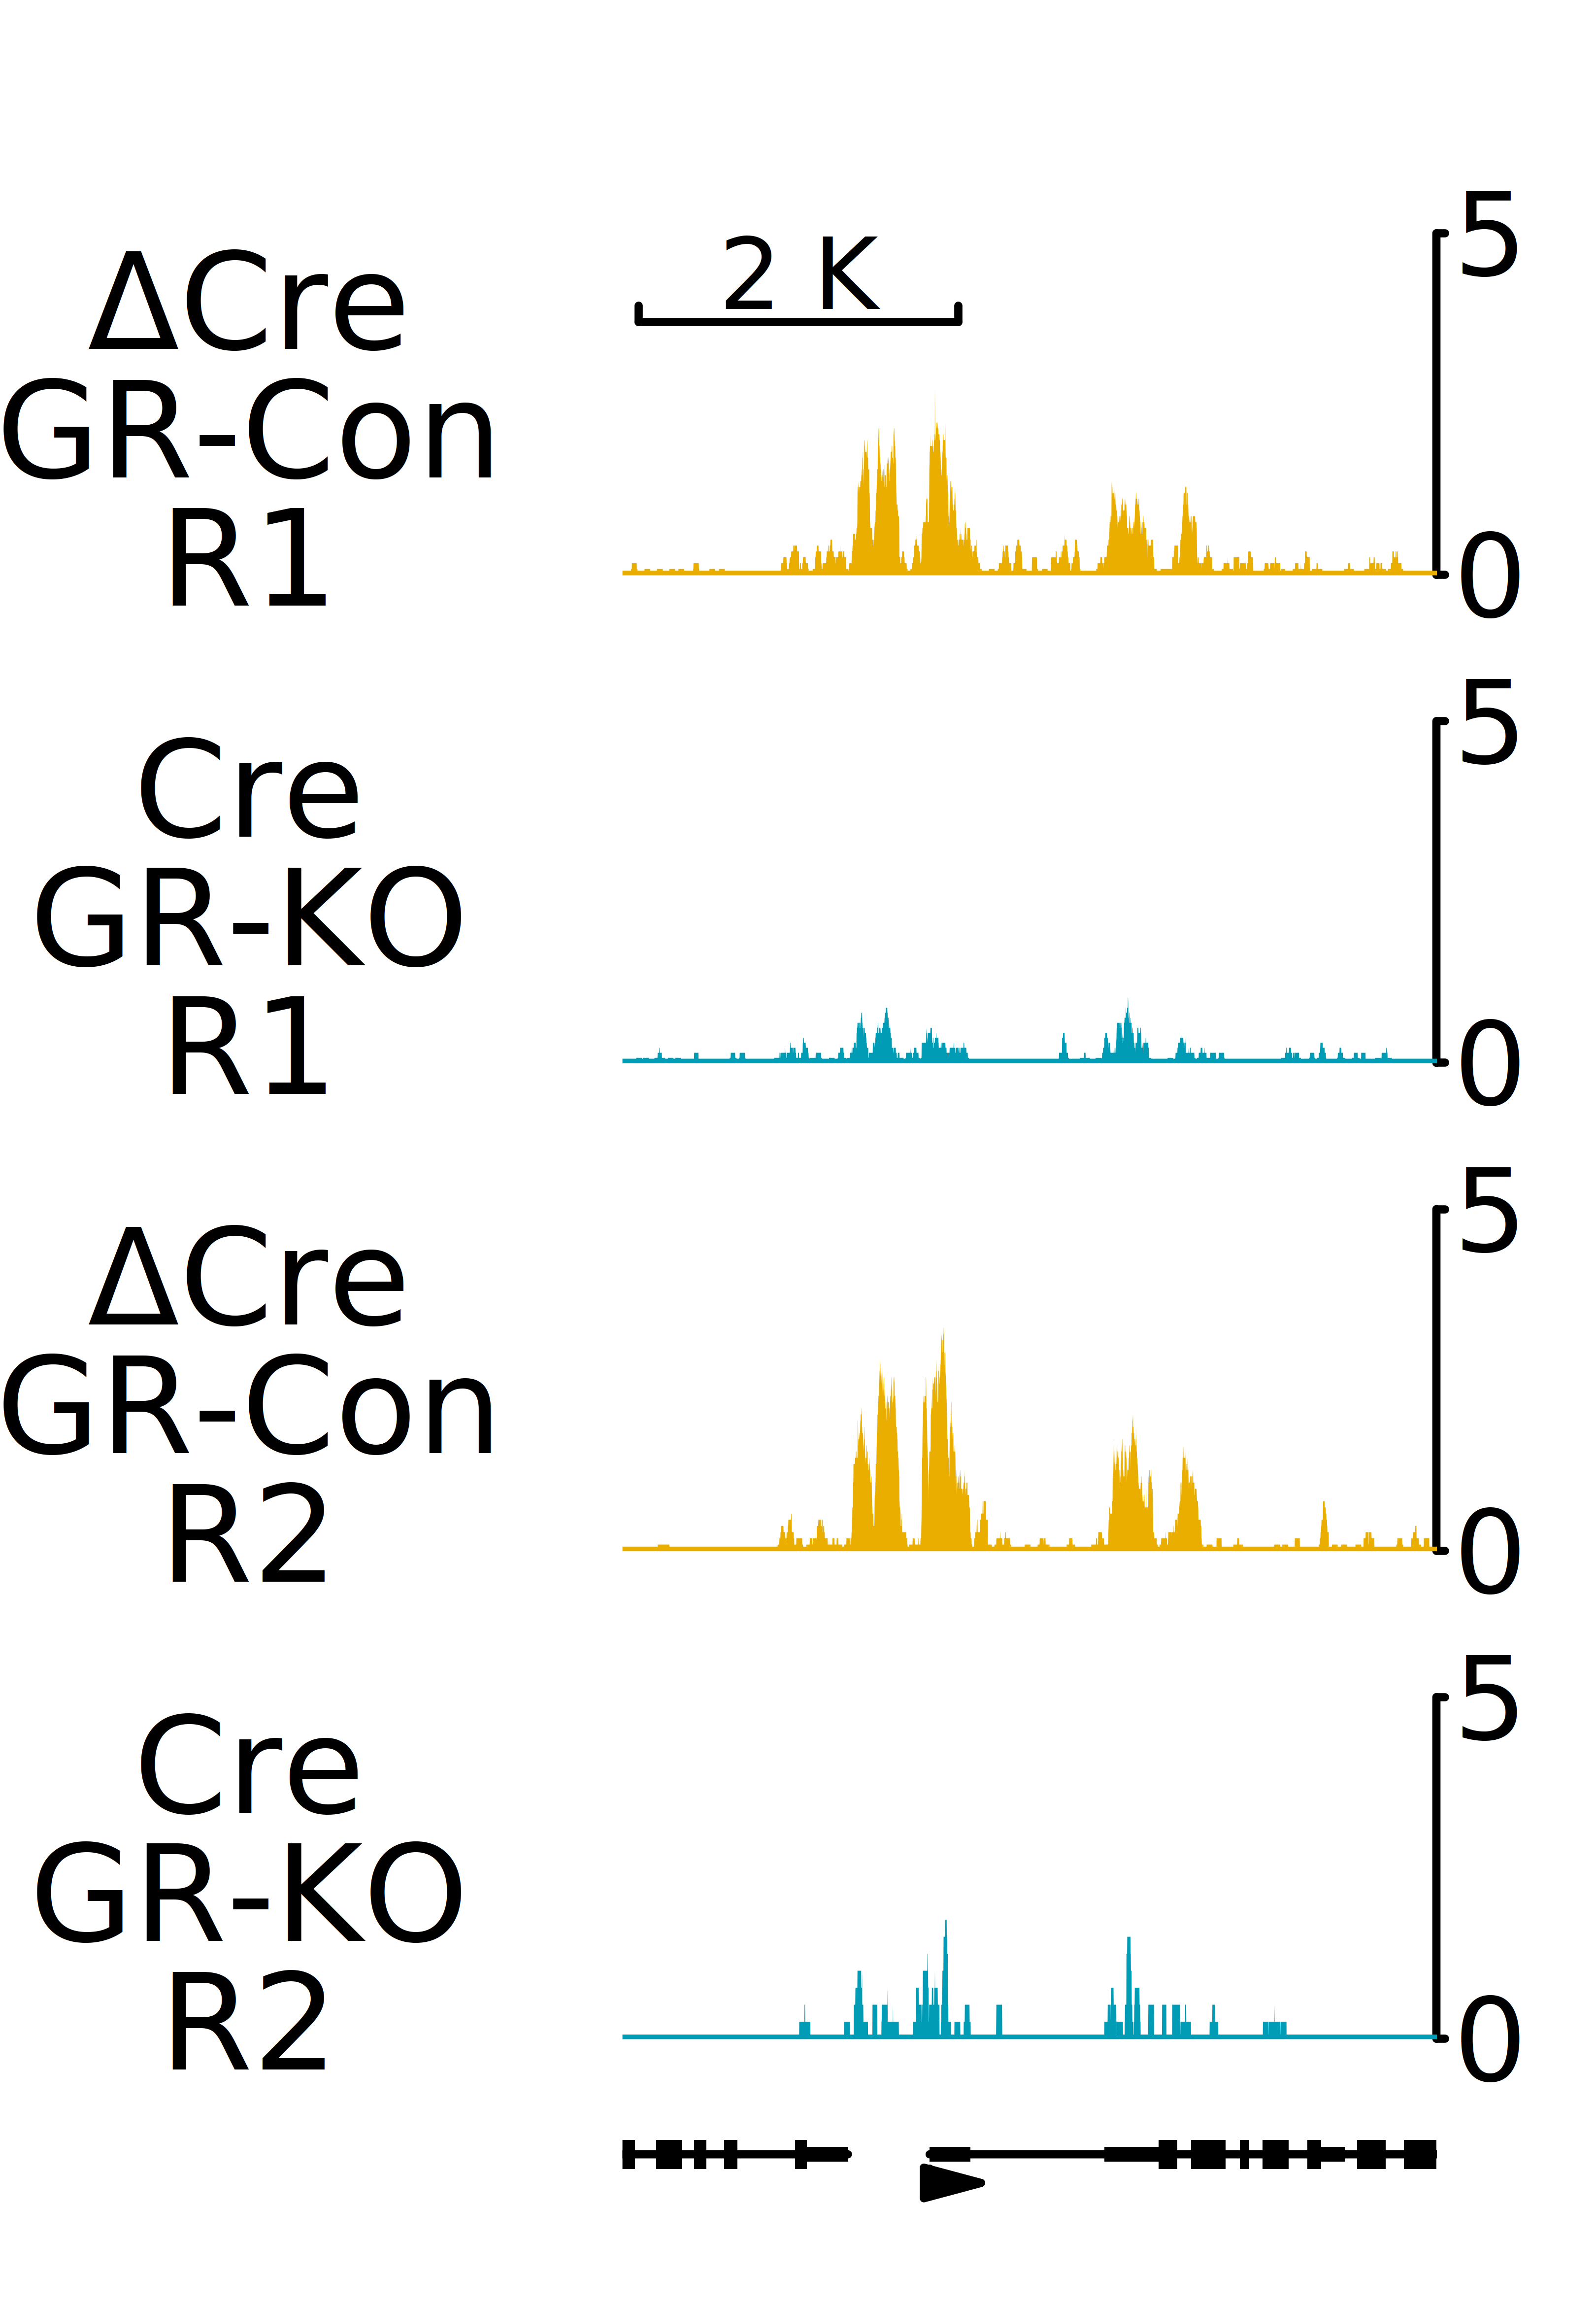

In [30]:
# Generate Aldoc track
gr <- GRanges("chr11", IRanges(78321048,78326135))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('ΔCre\nGR-Con\nR1',
                          'Cre\nGR-KO\nR1',
                          'ΔCre\nGR-Con\nR2',
                          'Cre\nGR-KO\nR2',''))


Con_color <- "#EAAE00"
KO_color <- "#009CB5"

options(repr.plot.width=1.8*1.5, repr.plot.height=2.6*1.5,repr.plot.res=1200)

setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(0, 0.39, .08, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[5]], "draw", TRUE)
setTrackXscaleParam(trackList[[5]], attr="position", 
                    value=list(x=start(gr)+1100, y=3.7, label=2000))
setTrackXscaleParam(trackList[[5]], "gp", list(size=6,lineheight=0.1))


setTrackStyleParam(trackList[[2]], "ylim", c(0, 5.0))
setTrackStyleParam(trackList[[3]], "ylim", c(0, 5.0))
setTrackStyleParam(trackList[[4]], "ylim", c(0, 5.0))
setTrackStyleParam(trackList[[5]], "ylim", c(0, 5.0))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "ylabgp", list(fontsize=0))
setTrackStyleParam(trackList[[1]], "color", 'black')

setTrackStyleParam(trackList[[2]], "color", KO_color)
setTrackStyleParam(trackList[[3]], "color", Con_color)
setTrackStyleParam(trackList[[4]], "color", KO_color)
setTrackStyleParam(trackList[[5]], "color", Con_color)

#setTrackStyleParam(trackList[[2]], "margin", "#009CB5")


setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

setTrackYaxisParam(trackList[[2]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[3]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[4]], "gp", list(lineheight=0.15,fontsize=14))
setTrackYaxisParam(trackList[[5]], "gp", list(lineheight=0.15,fontsize=14))

setTrackStyleParam(trackList[[2]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[3]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[4]], "ylabgp", list(lineheight=0.8,fontsize=16.3))
setTrackStyleParam(trackList[[5]], "ylabgp", list(lineheight=0.8,fontsize=16.3))

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

# Identify consensus NFIA sites (detected in 2/3 biological replicates) in astrocytes

In [ ]:
# Create DiffBind object
Astro_NFIA <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_sample_sheet.csv", peakFormat="narrow")
Astro_NFIA_count <- dba.count(Astro_NFIA,summits=150,minOverlap=2,bParallel = TRUE)

In [ ]:
# Export re-centered, consensus sites as BED file
rtracklayer::export(GRanges(seqnames = Astro_NFIA_count$peaks[[1]]$Chr,
                            IRanges(start = Astro_NFIA_count$peaks[[1]]$Start,
                                    end = Astro_NFIA_count$peaks[[1]]$End)),
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_consensus.bed',
                    format = 'BED')

# Annotate NFIA peaks to promoter sites and non-promoter sites for motif analysis

In [ ]:
# Annotate GR sites to mm10
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
peakAnno <- annotatePeak('/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_consensus.bed',
                         tssRegion=c(-1000, 1000),
                         genomicAnnotationPriority = c("Promoter", "Exon", "Intron",
                                                        "Downstream", "Intergenic"),
                         level = 'gene',
                         TxDb=txdb, annoDb="org.Mm.eg.db")

In [ ]:
# Export data with nearest gene annotation
write.table(as.data.frame(peakAnno),
            '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/SuppTable6.csv',
            quote=FALSE,
            row.names=FALSE,
            col.names=TRUE,
            sep='\t')

In [ ]:
# Generate dataframe of peak annotation proportions
anno_df <- as.data.frame(t(data.frame(Promoter = 35.44705680,
                      Exon = 5.49167668 + 5.26428694,
                      Intron = 12.43778960 + 19.77432641,
                      Intergenic = 0.09009782 + 21.49476575)))
anno_df$x <- 1
anno_df$anno <- rownames(anno_df)
anno_df$anno <- factor(anno_df$anno, levels = c('Intergenic','Intron','Exon','Promoter'))

In [ ]:
# Generate bar plot
options(repr.plot.width=8, repr.plot.height=2,repr.plot.res=900)
ggplot(data = anno_df, aes(x = x, y = V1, fill=anno)) +
  geom_bar(stat="identity",width=0.5) + theme_bw() + theme(axis.title.y=element_blank(),
                                                           panel.grid.major = element_blank(),
                                                          panel.grid.minor = element_blank(),
                                                     axis.text.y=element_blank(),
                                                      axis.ticks.y=element_blank(),
                                                     axis.title.x=element_text(size=26,color='black'),
                                                      legend.title = element_blank(),
                                                      legend.position='right',
                                                           legend.margin=margin(0,0,0,25),
                                                      legend.text = element_text(size=24,color='black',margin=margin(0,15,0,0)),
                                                      axis.text.x=element_text(size=22,color='black')) +
ylab('% of NFIA sites') + scale_fill_manual(values = as.vector(paletteer::paletteer_d("LaCroixColoR::PeachPear")[1:4])) +
guides(fill = guide_legend(nrow = 4)) + coord_flip()

In [ ]:
# Generate granges objects
peakAnno_df <- as.data.frame(peakAnno)

prom_gr <- GRanges(
  seqnames = peakAnno_df[peakAnno_df$annotation == 'Promoter','seqnames'],  
  ranges = IRanges(start = peakAnno_df[peakAnno_df$annotation == 'Promoter','start'], 
                   end = peakAnno_df[peakAnno_df$annotation == 'Promoter','end'])
)

nonprom_gr <- GRanges(
  seqnames = peakAnno_df[peakAnno_df$annotation != 'Promoter','seqnames'],  
  ranges = IRanges(start = peakAnno_df[peakAnno_df$annotation != 'Promoter','start'], 
                   end = peakAnno_df[peakAnno_df$annotation != 'Promoter','end'])
)

In [ ]:
# Export promoter vs. non-promoter sites for motif analysis
# Export as BED file
rtracklayer::export(prom_gr,
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_consensus_prom.col.bed',
                    format = 'BED')

rtracklayer::export(nonprom_gr,
					'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_consensus_nonprom.col.bed',
                    format = 'BED')

# Generate euler overlap of astrocyte GR and NFIA peaks

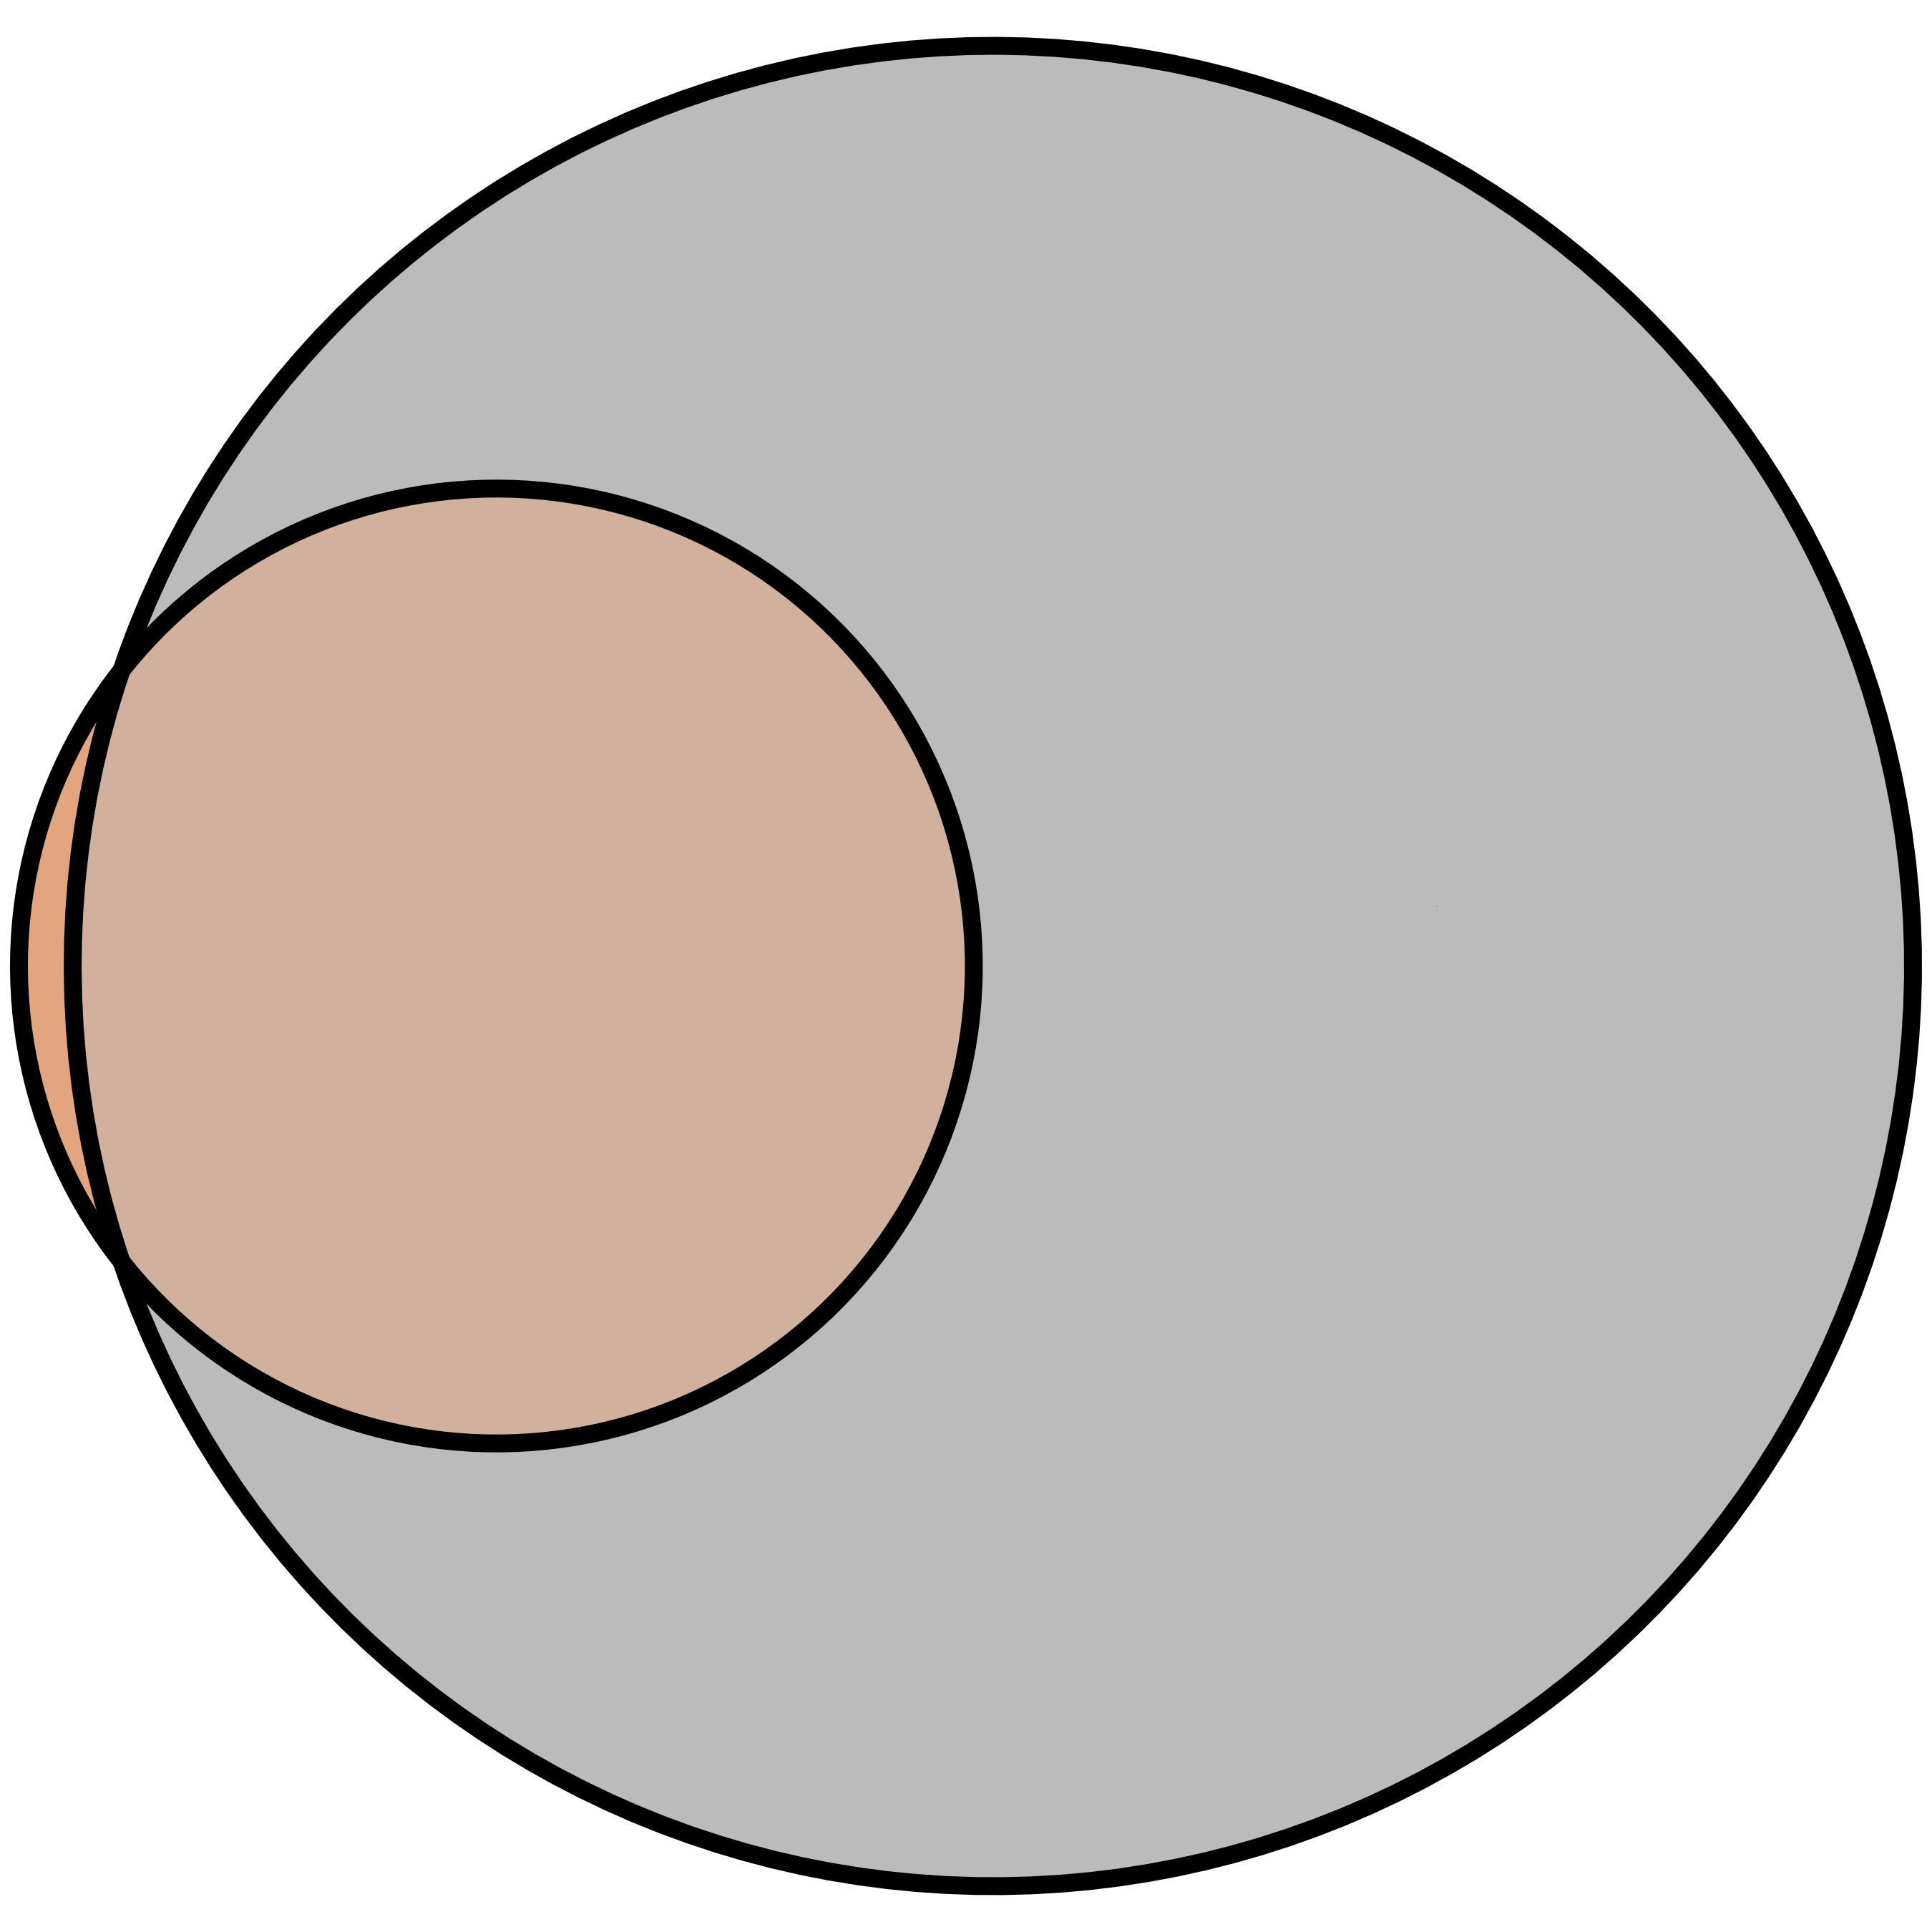

In [101]:
# Import results from bedtools intersect
# Generate plots
DEG_overlap <- c(
  'GR' = 193,
  'NFIA' = 17224,
  "GR&NFIA" = 6081
)

options(repr.plot.width=3, repr.plot.height=3,repr.plot.res=900)
fit3 <- euler(DEG_overlap, shape = "ellipse")
plot(fit3,
     lwd=2,
    fills = list(fill = c('#DE9B71', "grey70"), alpha = 0.9),
     labels = list(col = "black", fontsize = 0))

# Identify GR consensus sites (in 2/3 biological replicates) in other purified cell types (excitatory neurons, inhibitory neurons, oligodendrocytes)

In [9]:
# Calculate GR consensus sites for each cell type
# Vglut1
Vglut_GR <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Vglut_GR_820.csv", peakFormat="narrow")
Vglut_GR_count <- dba.count(Vglut_GR,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Vglut_GR_820.csv'"
Vglut_R1 Vglut GR NR NR 1 bed

Vglut_R2 Vglut GR NR NR 2 bed

Vglut_R3 Vglut GR NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 939 sites in matrix:
        ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 Vglut_R1  Vglut     GR        NR        NR         1 4984427 0.02
2 Vglut_R2  Vglut     GR        NR        NR         2 6004732 0.01
3 Vglut_R3  Vglut     GR        NR        NR         3 5861576 0.02

In [11]:
# Vgat
Vgat_GR <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Vgat_GR_825.csv", peakFormat="narrow")
Vgat_GR_count <- dba.count(Vgat_GR,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Vgat_GR_825.csv'"
Vgat_R1 Vgat GR NR NR 1 bed

Vgat_R2 Vgat GR NR NR 2 bed

Vgat_R3 Vgat GR NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 764 sites in matrix:
       ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 Vgat_R1   Vgat     GR        NR        NR         1 5948722 0.01
2 Vgat_R2   Vgat     GR        NR        NR         2 7517589 0.01
3 Vgat_R3   Vgat     GR        NR        NR         3 7782262 0.01

In [14]:
# Olig2
Olig2_GR <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Olig2_GR_913.csv", peakFormat="narrow")
Olig2_GR_count <- dba.count(Olig2_GR,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/samplesheets/Olig2_GR_913.csv'"
Olig2_R1 Olig2 GR NR NR 1 bed

Olig2_R2 Olig2 GR NR NR 2 bed

Olig2_R3 Olig2 GR NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 48 sites in matrix:
        ID Tissue Factor Condition Treatment Replicate   Reads
1 Olig2_R1  Olig2     GR        NR        NR         1 4629928
2 Olig2_R2  Olig2     GR        NR        NR         2 5205644
3 Olig2_R3  Olig2     GR        NR        NR         3 7172131

In [102]:
# Astrocytes
Astro_GR <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/sample_sheet_01.csv", peakFormat="narrow")
Astro_GR_count <- dba.count(Astro_GR,summits=150,minOverlap=2,bParallel = TRUE)

DR_R1 Astro CR DR DR 1 bed

DR_R2 Astro CR DR DR 2 bed

DR_R3 Astro CR DR DR 3 bed

NR_R1 Astro CR NR NR 1 bed

NR_R2 Astro CR NR NR 2 bed

NR_R3 Astro CR NR NR 3 bed

Computing summits...

Re-centering peaks...



6 Samples, 12459 sites in matrix:
     ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 DR_R1  Astro     CR        DR        DR         1 5005092 0.03
2 DR_R2  Astro     CR        DR        DR         2 6312296 0.02
3 DR_R3  Astro     CR        DR        DR         3 3269938 0.05
4 NR_R1  Astro     CR        NR        NR         1 5574968 0.12
5 NR_R2  Astro     CR        NR        NR         2 3373049 0.07
6 NR_R3  Astro     CR        NR        NR         3 5923862 0.17

In [103]:
# Collect all counts into dataframe
GR_peak_df <- data.frame(Astro = dim(Astro_GR_count$peaks[[1]])[1],
                           Oligo = dim(Olig2_GR_count$peaks[[1]])[1],
                           ExN = dim(Vglut_GR_count$peaks[[1]])[1],
                           InN = dim(Vgat_GR_count$peaks[[1]])[1])

GR_peak_df_melt <- reshape2::melt(GR_peak_df)

No id variables; using all as measure variables



In [104]:
# Set colors
Astro_color <- '#DE9B71'
Olig2_color <- '#78DE71'
Vglut_color <- '#71B6DE'
Vgat_color <-  '#DE6F5B'

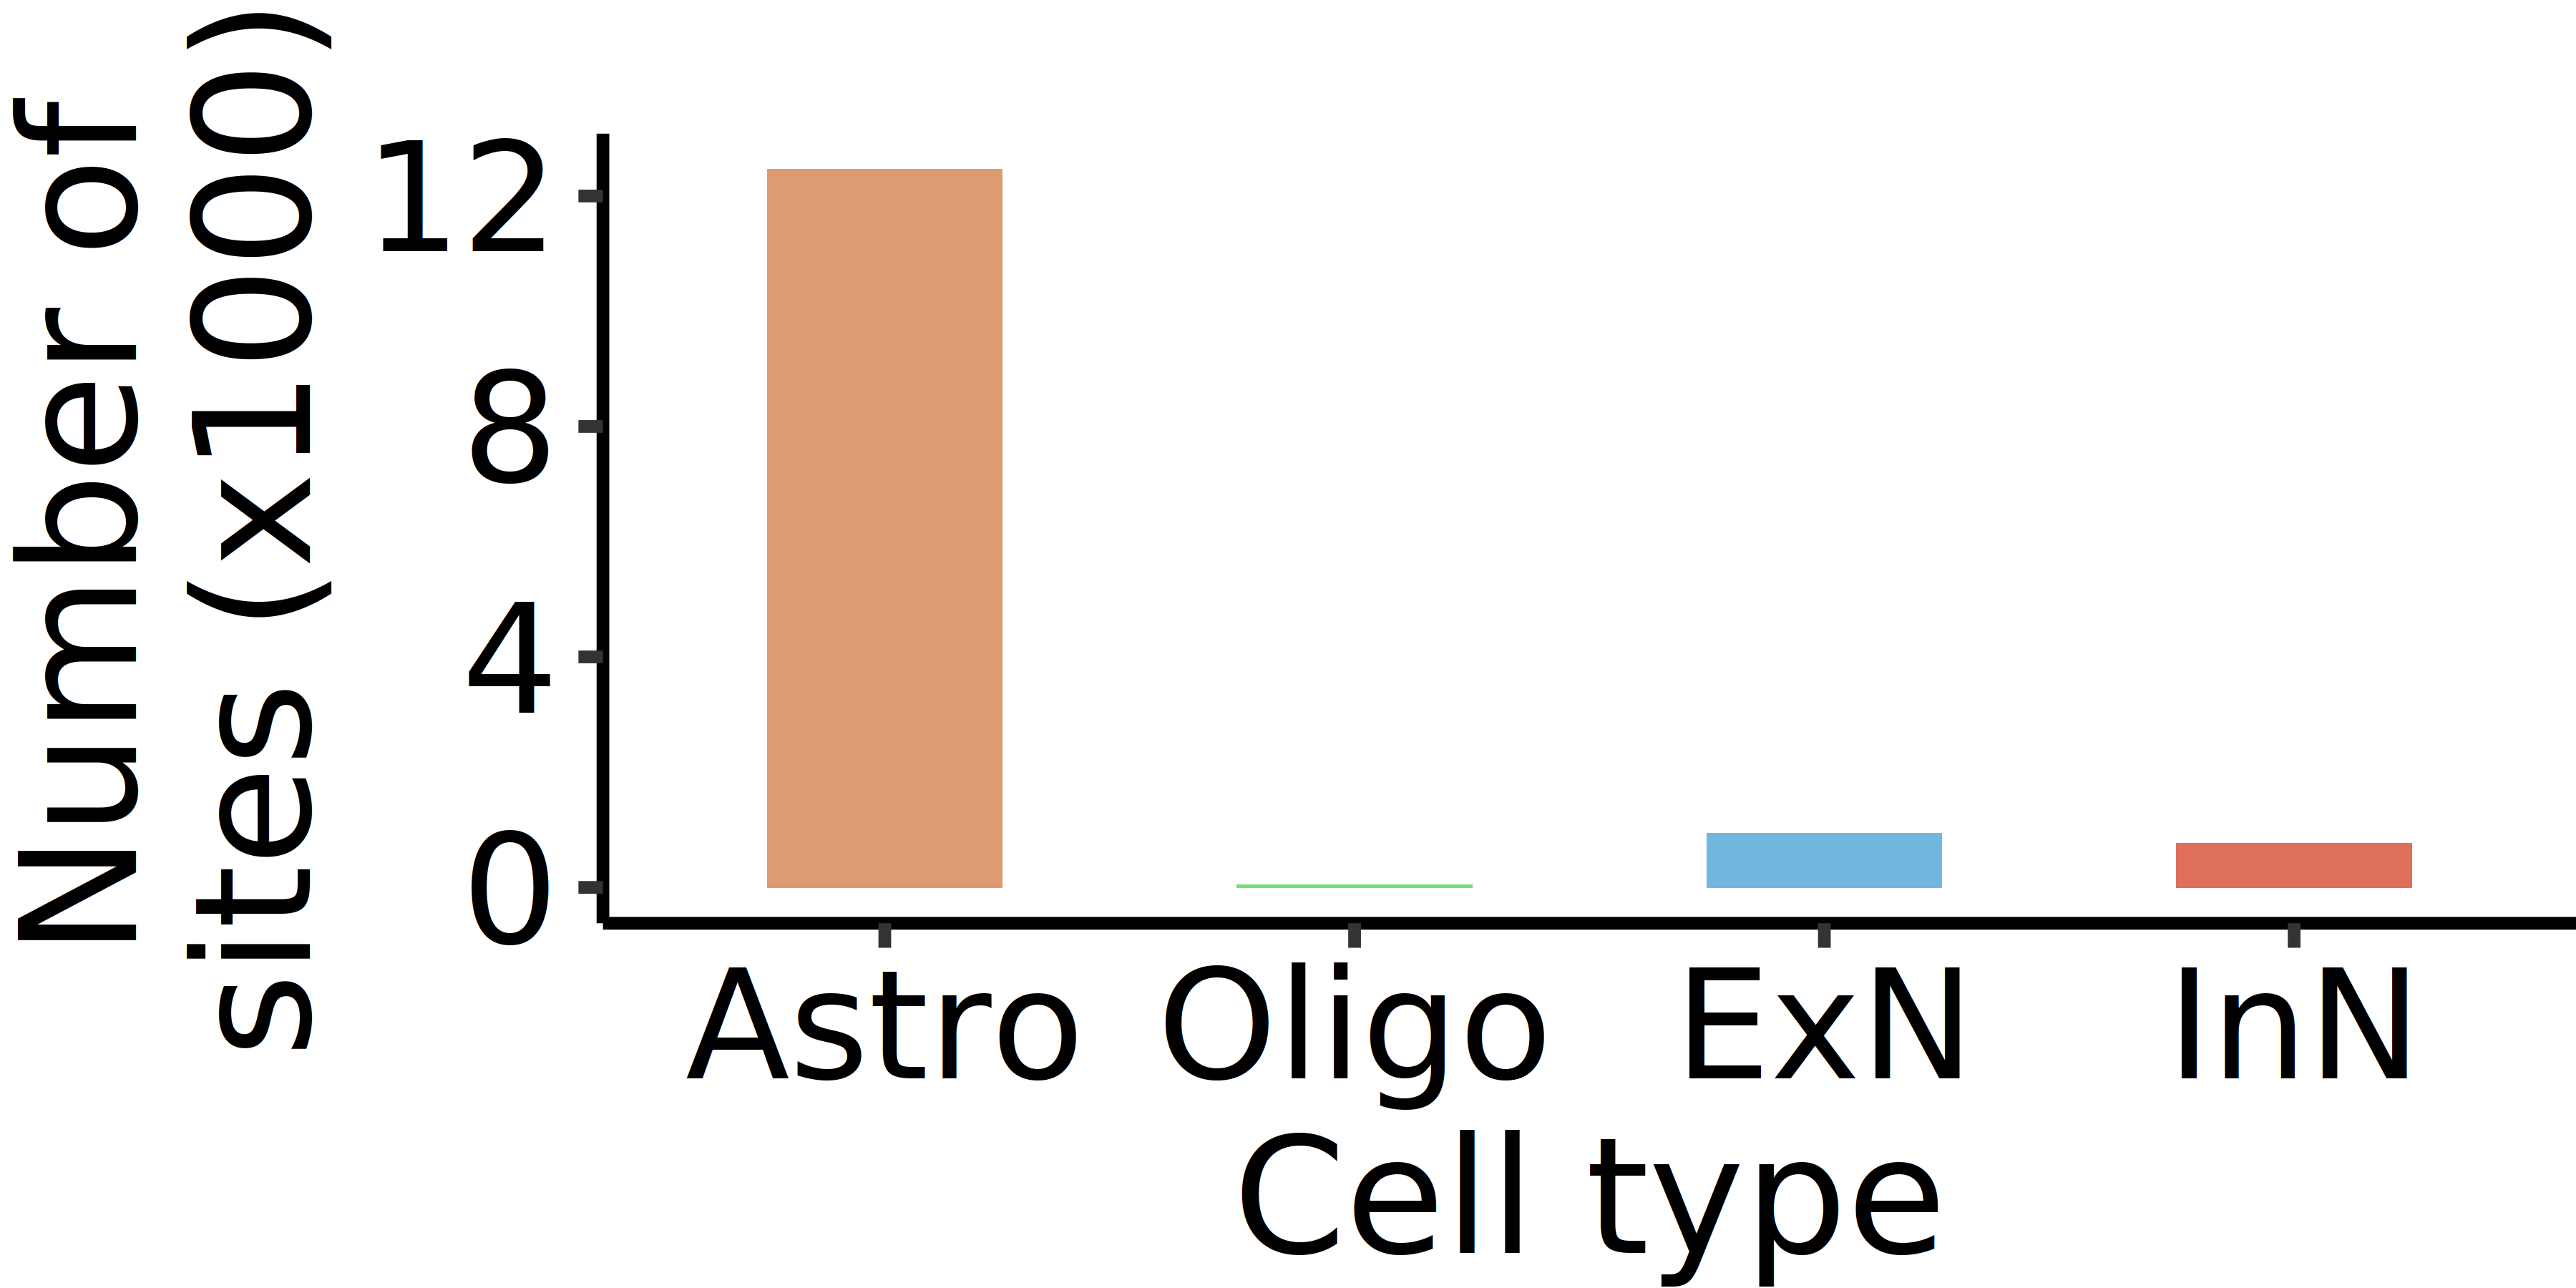

In [105]:
# Generate barplot of peak number
options(repr.plot.width=4, repr.plot.height=2,repr.plot.res=900)

GR_peak_df_melt$value_scale <- GR_peak_df_melt$value / 1000

p<-ggplot(data = GR_peak_df_melt, aes(x = variable, y = value_scale, fill = variable)) +
  geom_bar(stat="identity",width=0.5) + theme_classic() + theme(axis.text = element_text(color='black',size=17),
                                                      axis.title = element_text(color='black',size=18),
                                                      legend.position='none',
                                                      plot.margin=margin(15,0,0,2),
                                                     axis.title.y = element_text(margin=margin(0,5,0,0))) + xlab('Cell type') + ylab('Number of\nsites (x1000)') +
scale_fill_manual(values=c(Astro_color, Olig2_color, Vglut_color, Vgat_color))
p 

In [ ]:
# Save dba objects as rds file
saveRDS(list(Astro = Astro_GR_count,
     Oligo = Olig2_GR_count,
     ExN =   Vglut_GR_count,
     InN =   Vgat_GR_count),'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/GR_dba_objects.rds')

# Identify NFIA consensus sites (in 2/3 biological replicates) in other purified cell types (excitatory neurons, inhibitory neurons, oligodendrocytes)

In [2]:
# Calculate NFIA consensus sites for each cell type
# Vglut
Vglut_NFIA <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Vglut_NFIA_820.csv", peakFormat="narrow")
Vglut_NFIA_count <- dba.count(Vglut_NFIA,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Vglut_NFIA_820.csv'"
Vglut_R1 Vglut NFIA NR NR 1 bed

Vglut_R2 Vglut NFIA NR NR 2 bed

Vglut_R3 Vglut NFIA NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 215 sites in matrix:
        ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 Vglut_R1  Vglut   NFIA        NR        NR         1 5021204 0.01
2 Vglut_R2  Vglut   NFIA        NR        NR         2 5735784 0.00
3 Vglut_R3  Vglut   NFIA        NR        NR         3 6848054 0.00

In [4]:
# Vgat
Vgat_NFIA <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Vgat_NFIA_825.csv", peakFormat="narrow")
Vgat_NFIA_count <- dba.count(Vgat_NFIA,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Vgat_NFIA_825.csv'"
Vgat_R1 Vgat NFIA NR NR 1 bed

Vgat_R2 Vgat NFIA NR NR 2 bed

Vgat_R3 Vgat NFIA NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 442 sites in matrix:
       ID Tissue Factor Condition Treatment Replicate   Reads
1 Vgat_R1   Vgat   NFIA        NR        NR         1 6215141
2 Vgat_R2   Vgat   NFIA        NR        NR         2 5318510
3 Vgat_R3   Vgat   NFIA        NR        NR         3 5817917

In [7]:
# Olig2
Olig2_NFIA <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Olig2_NFIA_913.csv", peakFormat="narrow")
Olig2_NFIA_count <- dba.count(Olig2_NFIA,summits=150,minOverlap=2,bParallel = TRUE)

Warning message in read.table(samplesheet, sep = ",", stringsAsFactors = FALSE, :
"incomplete final line found by readTableHeader on '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/samplesheets/Olig2_NFIA_913.csv'"
Olig2_R1 Olig2 NFIA NR NR 1 bed

Olig2_R2 Olig2 NFIA NR NR 2 bed

Olig2_R3 Olig2 NFIA NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 192 sites in matrix:
        ID Tissue Factor Condition Treatment Replicate   Reads
1 Olig2_R1  Olig2   NFIA        NR        NR         1 5603043
2 Olig2_R2  Olig2   NFIA        NR        NR         2 4564330
3 Olig2_R3  Olig2   NFIA        NR        NR         3 5176982

In [8]:
# Astrocytes
Astro_NFIA <- dba(sampleSheet = "/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_sample_sheet.csv", peakFormat="narrow")
Astro_NFIA_count <- dba.count(Astro_NFIA,summits=150,minOverlap=2,bParallel = TRUE)

NFIA_R1 Astro NFIA NR NR 1 bed

NFIA_R2 Astro NFIA NR NR 2 bed

NFIA_R3 Astro NFIA NR NR 3 bed

Computing summits...

Re-centering peaks...



3 Samples, 23308 sites in matrix:
       ID Tissue Factor Condition Treatment Replicate   Reads FRiP
1 NFIA_R1  Astro   NFIA        NR        NR         1 6661306 0.24
2 NFIA_R2  Astro   NFIA        NR        NR         2 6263788 0.23
3 NFIA_R3  Astro   NFIA        NR        NR         3 6665312 0.20

In [29]:
# Collect all counts into dataframe
NFIA_peak_df <- data.frame(Astro = dim(Astro_NFIA_count$peaks[[1]])[1],
                           Oligo = dim(Olig2_NFIA_count$peaks[[1]])[1],
                           ExN = dim(Vglut_NFIA_count$peaks[[1]])[1],
                           InN = dim(Vgat_NFIA_count$peaks[[1]])[1])

NFIA_peak_df_melt <- reshape2::melt(NFIA_peak_df)

No id variables; using all as measure variables



In [42]:
# Set colors
Astro_color <- '#DE9B71'
Olig2_color <- '#78DE71'
Vglut_color <- '#71B6DE'
Vgat_color <-  '#DE6F5B'

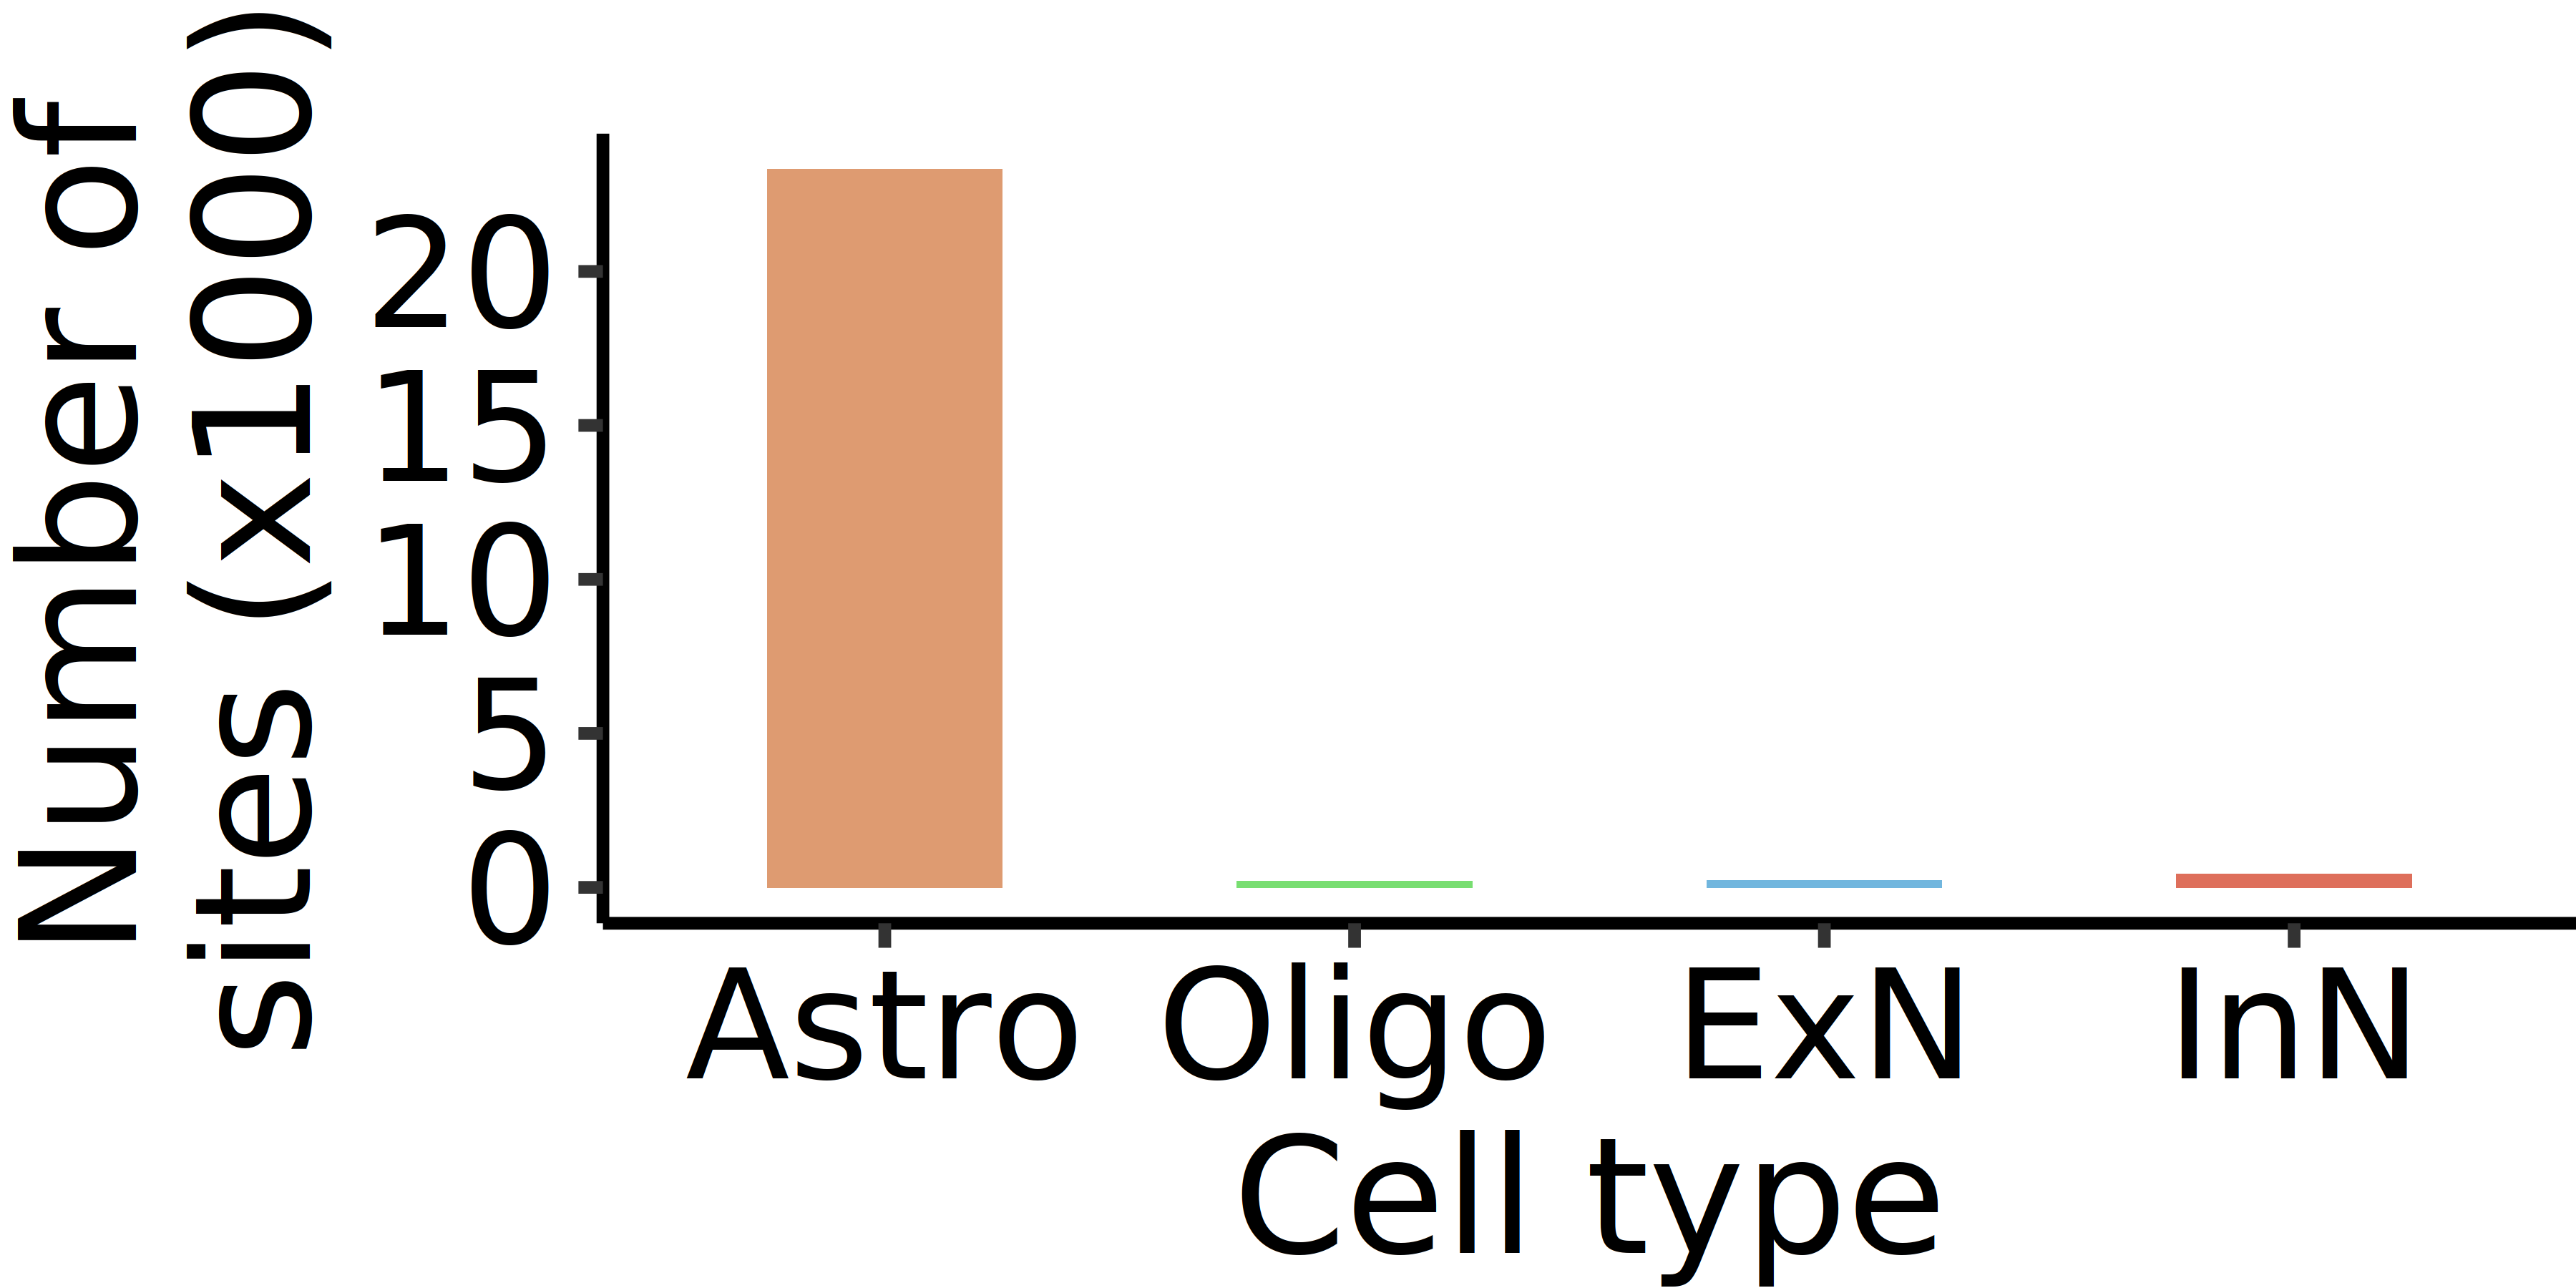

In [88]:
# Generate bar plot
options(repr.plot.width=4, repr.plot.height=2,repr.plot.res=900)

NFIA_peak_df_melt$value_scale <- NFIA_peak_df_melt$value / 1000

p<-ggplot(data = NFIA_peak_df_melt, aes(x = variable, y = value_scale, fill = variable)) +
  geom_bar(stat="identity",width=0.5) + theme_classic() + theme(axis.text = element_text(color='black',size=17),
                                                      axis.title = element_text(color='black',size=18),
                                                      legend.position='none',
                                                      plot.margin=margin(15,0,0,2),
                                                     axis.title.y = element_text(margin=margin(0,5,0,0))) + xlab('Cell type') + ylab('Number of\nsites (x1000)') +
scale_fill_manual(values=c(Astro_color, Olig2_color, Vglut_color, Vgat_color))
p 

In [89]:
# Save dba objects as rds file
saveRDS(list(Astro = Astro_NFIA_count,
     Oligo = Olig2_NFIA_count,
     ExN = Vglut_NFIA_count,
     InN = Vgat_NFIA_count),'/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/NFIA_dba_objects.rds')

# Generate GR & NFIA binding tracks across cell types

In [ ]:
# Load bigwig files
fp_list <- list(Astro_DR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_DR_IgG_R1.bw',
                Astro_NR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_NR_IgG_R1.bw',
                Astro_DR_GR =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_DR_GR_merge.bw',
                Astro_NR_GR =  '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_DR_NR/Astro_NR_GR_merge.bw',
                Astro_NR_NFIA = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/Astro_NFIA/Astro_NFIA_merge.bw',
                Olig2_NR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Olig2_IgG_913_R1.bw',
                Olig2_NR_GR = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Olig2_GR_merge.bw',
                Olig2_NR_NFIA = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/Olig2_NFIA_merge.bw',
                ExN_NR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Vglut_IgG_915_R1.bw',
                ExN_NR_GR = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Vglut_GR_merge.bw',
                ExN_NR_NFIA = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/Vglut_NFIA_merge.bw',
                InN_NR_IgG = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Vgat_IgG_919_R1.bw',
                InN_NR_GR = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/GR_othercells/Vgat_GR_merge.bw',
                InN_NR_NFIA = '/n/groups/neuroduo/Bruno/Cell_type_GR_CnR_v2/NFIA_othercells/Vgat_NFIA_merge.bw')

In [ ]:
# Generate Mt1 track
gr <- GRanges("chr8", IRanges(94168504,94192532))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      cov_list[[7]],
                                      cov_list[[8]],
                                      cov_list[[9]],
                                      cov_list[[10]],
                                      cov_list[[11]],
                                      cov_list[[12]],
                                      cov_list[[13]],
                                      cov_list[[14]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('Astro\nDR IgG',
                          'Astro\nNR IgG',
                          'Astro\nDR GR',
                          'Astro\nNR GR',
                          'Astro\nNFIA',
                          'Oligo\nIgG',
                          'Oligo\nGR',
                          'Oligo\nNFIA',
                          'ExN\nIgG',
                          'ExN\nGR',
                          'ExN\nNFIA',
                          'InN\nIgG',
                          'InN\nGR',
                          'InN\nNFIA',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Olig2_color <- "#78DE71"
Vgat_color <- '#DE6F5B'
Vglut_color <- '#71B6DE'	



options(repr.plot.width=2.8, repr.plot.height=7,repr.plot.res=1200)

setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(0, 0.25, 0.01, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[15]], "draw", TRUE)
setTrackXscaleParam(trackList[[15]], attr="position", 
                    value=list(x=start(gr)+3000, y=2.7, label=5000))
setTrackXscaleParam(trackList[[15]], "gp", list(lineheight=0.1,fontsize=10))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylim", c(0, 6.0))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "ylabgp", list(fontsize=0))
setTrackStyleParam(trackList[[1]], "color", 'black')

setTrackStyleParam(trackList[[2]], "color", Vgat_color)
setTrackStyleParam(trackList[[3]], "color", Vgat_color)
setTrackStyleParam(trackList[[4]], "color", Vgat_color)

setTrackStyleParam(trackList[[5]], "color", Vglut_color)
setTrackStyleParam(trackList[[6]], "color", Vglut_color)
setTrackStyleParam(trackList[[7]], "color", Vglut_color)

setTrackStyleParam(trackList[[8]], "color", Olig2_color)
setTrackStyleParam(trackList[[9]], "color", Olig2_color)
setTrackStyleParam(trackList[[10]], "color", Olig2_color)

setTrackStyleParam(trackList[[11]], "color", NR_color)
setTrackStyleParam(trackList[[12]], "color", NR_color)
setTrackStyleParam(trackList[[13]], "color", DR_color)
setTrackStyleParam(trackList[[14]], "color", NR_color)
setTrackStyleParam(trackList[[15]], "color", DR_color)

setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

for(i in seq(2,length(trackList)))  {
    setTrackYaxisParam(trackList[[i]], "gp", list(lineheight=0.15,fontsize=10))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabgp", list(lineheight=0.9,fontsize=40))
}

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

In [ ]:
# Generate Cables track
gr <- GRanges("chr18", IRanges(11898931,11905216))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      cov_list[[7]],
                                      cov_list[[8]],
                                      cov_list[[9]],
                                      cov_list[[10]],
                                      cov_list[[11]],
                                      cov_list[[12]],
                                      cov_list[[13]],
                                      cov_list[[14]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('Astro\nDR IgG',
                          'Astro\nNR IgG',
                          'Astro\nDR GR',
                          'Astro\nNR GR',
                          'Astro\nNFIA',
                          'Oligo\nIgG',
                          'Oligo\nGR',
                          'Oligo\nNFIA',
                          'ExN\nIgG',
                          'ExN\nGR',
                          'ExN\nNFIA',
                          'InN\nIgG',
                          'InN\nGR',
                          'InN\nNFIA',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Olig2_color <- "#78DE71"
Vgat_color <- '#DE6F5B'
Vglut_color <- '#71B6DE'	



options(repr.plot.width=2.8, repr.plot.height=7,repr.plot.res=1200)

setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(0, 0.25, 0.01, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[15]], "draw", TRUE)
setTrackXscaleParam(trackList[[15]], attr="position", 
                    value=list(x=start(gr)+1200, y=3.5, label=2000))
setTrackXscaleParam(trackList[[15]], "gp", list(lineheight=0.1,fontsize=10))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylim", c(0, 6.0))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "ylabgp", list(fontsize=0))
setTrackStyleParam(trackList[[1]], "color", 'black')

setTrackStyleParam(trackList[[2]], "color", Vgat_color)
setTrackStyleParam(trackList[[3]], "color", Vgat_color)
setTrackStyleParam(trackList[[4]], "color", Vgat_color)

setTrackStyleParam(trackList[[5]], "color", Vglut_color)
setTrackStyleParam(trackList[[6]], "color", Vglut_color)
setTrackStyleParam(trackList[[7]], "color", Vglut_color)

setTrackStyleParam(trackList[[8]], "color", Olig2_color)
setTrackStyleParam(trackList[[9]], "color", Olig2_color)
setTrackStyleParam(trackList[[10]], "color", Olig2_color)

setTrackStyleParam(trackList[[11]], "color", NR_color)
setTrackStyleParam(trackList[[12]], "color", NR_color)
setTrackStyleParam(trackList[[13]], "color", DR_color)
setTrackStyleParam(trackList[[14]], "color", NR_color)
setTrackStyleParam(trackList[[15]], "color", DR_color)

setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

for(i in seq(2,length(trackList)))  {
    setTrackYaxisParam(trackList[[i]], "gp", list(lineheight=0.15,fontsize=10))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabgp", list(lineheight=0.9,fontsize=40))
}

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)

In [ ]:
# Generate Fam107a track
gr <- GRanges("chr14", IRanges(8303258,8318707))

score_list <- lapply(fp_list, function(x) {
import_sc <- importScore(file.path(x),
                    format="BigWig",
                    ranges = gr)
    return(import_sc)
})

# Generate gene track
ids <- getGeneIDsFromTxDb(gr, TxDb.Mmusculus.UCSC.mm10.knownGene)
symbols <- mget(ids, org.Mm.egSYMBOL)
genes <- geneTrack(ids, TxDb.Mmusculus.UCSC.mm10.knownGene, 
                  symbols, asList=FALSE)

cov_list <- lapply(score_list, function(x) {
        x$dat <- coverageGR(x$dat)
    return(x)
})

optSty <- optimizeStyle(rev(trackList(cov_list[[1]],
                                      cov_list[[2]],
                                      cov_list[[3]],
                                      cov_list[[4]],
                                      cov_list[[5]],
                                      cov_list[[6]],
                                      cov_list[[7]],
                                      cov_list[[8]],
                                      cov_list[[9]],
                                      cov_list[[10]],
                                      cov_list[[11]],
                                      cov_list[[12]],
                                      cov_list[[13]],
                                      cov_list[[14]],
                                      genes)),theme='safe')
trackList <- optSty$tracks
viewerStyle <- optSty$style

names(trackList) <- rev(c('Astro\nDR IgG',
                          'Astro\nNR IgG',
                          'Astro\nDR GR',
                          'Astro\nNR GR',
                          'Astro\nNFIA',
                          'Oligo\nIgG',
                          'Oligo\nGR',
                          'Oligo\nNFIA',
                          'ExN\nIgG',
                          'ExN\nGR',
                          'ExN\nNFIA',
                          'InN\nIgG',
                          'InN\nGR',
                          'InN\nNFIA',''))

DR_color <- '#675478'
NR_color <- '#DE9B71'
Olig2_color <- "#78DE71"
Vgat_color <- '#DE6F5B'
Vglut_color <- '#71B6DE'	



options(repr.plot.width=2.8, repr.plot.height=7,repr.plot.res=1200)

setTrackViewerStyleParam(viewerStyle, "xaxis", FALSE)
setTrackViewerStyleParam(viewerStyle, "margin", c(0, 0.25, 0.01, 0.1))

for(i in seq(1,length(trackList))){
    setTrackYaxisParam(trackList[[i]], "main", FALSE)
}

setTrackXscaleParam(trackList[[2]], "draw", FALSE)
setTrackXscaleParam(trackList[[15]], "draw", TRUE)
setTrackXscaleParam(trackList[[15]], attr="position", 
                    value=list(x=start(gr)+3000, y=2.7, label=5000))
setTrackXscaleParam(trackList[[15]], "gp", list(lineheight=0.1,fontsize=10))

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylim", c(0, 5.0))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabpos", "left")
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylablas", 1)
}

setTrackStyleParam(trackList[[1]], "marginTop", -0.4)

setTrackStyleParam(trackList[[1]], "ylabgp", list(fontsize=0))
setTrackStyleParam(trackList[[1]], "color", 'black')

setTrackStyleParam(trackList[[2]], "color", Vgat_color)
setTrackStyleParam(trackList[[3]], "color", Vgat_color)
setTrackStyleParam(trackList[[4]], "color", Vgat_color)

setTrackStyleParam(trackList[[5]], "color", Vglut_color)
setTrackStyleParam(trackList[[6]], "color", Vglut_color)
setTrackStyleParam(trackList[[7]], "color", Vglut_color)

setTrackStyleParam(trackList[[8]], "color", Olig2_color)
setTrackStyleParam(trackList[[9]], "color", Olig2_color)
setTrackStyleParam(trackList[[10]], "color", Olig2_color)

setTrackStyleParam(trackList[[11]], "color", NR_color)
setTrackStyleParam(trackList[[12]], "color", NR_color)
setTrackStyleParam(trackList[[13]], "color", DR_color)
setTrackStyleParam(trackList[[14]], "color", NR_color)
setTrackStyleParam(trackList[[15]], "color", DR_color)

setTrackStyleParam(trackList[[1]], "height", 0.08)
for(i in 2:length(trackList)){
    setTrackStyleParam(trackList[[i]], "height", 
                       (1-0.08)/(length(trackList)-1))
}

for(i in seq(2,length(trackList)))  {
    setTrackYaxisParam(trackList[[i]], "gp", list(lineheight=0.15,fontsize=10))
}

for(i in seq(2,length(trackList)))  {
    setTrackStyleParam(trackList[[i]], "ylabgp", list(lineheight=0.9,fontsize=40))
}

viewTracks(trackList, gr=gr, autoOptimizeStyle=FALSE, newpage=TRUE,viewerStyle=viewerStyle)